# Analytics - Product Quality

#### Date: 2020/12

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2022/02
##### Professor: Hilmer Neri

##### Members:

- Flávio Vieira
- Francisco Emanoel
- Ian Filipe
- Ítalo Alves
- Ítalo Fernandes
- Ítalo Vinícius
- João Pedro Moura
- João Victor Valadão
- Lucas Melo
- Nilvan Peres
- Rafael Cleydson


### LIBRARIES

In [33]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [34]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [35]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [36]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2022-2-MeasureSoftGram-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'CLI': 'py',
    'Core': 'py',
    'Service': 'py',
    'Front': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [37]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/*.json')

## Create DataFrame

#### Unmarshall json

In [38]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [39]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [40]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [41]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [42]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [69]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

### Filter by limit date

In [45]:
file_component_df.head()

file_component_df['time'] = pd.to_datetime(file_component_df['datetime'], format='%m-%d-%Y-%H-%M-%S')

print(file_component_df.shape)

# Print max date of datetime column

print(file_component_df['time'].max())

# Filter rows datetime before 02-06-2023-8-0-0

file_component_df = file_component_df[file_component_df['time'] < '2023-02-06 08:00:00']

print(file_component_df.shape)
print(file_component_df['time'].max())


(6759, 20)
2023-02-09 02:55:54
(6528, 20)
2023-02-06 04:15:08


### Create dataframe per repository

In [46]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [47]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [48]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [49]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [50]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [51]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [52]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [53]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [75]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    filename = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        filename.append(version_df['filename'].iloc[0])

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list,
        'filename': filename
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [76]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

In [79]:
metrics['Front']['filename']

0     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-05...
1     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-05...
2     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-27...
3     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-27...
4     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-29...
5     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-30...
6     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-31...
7     fga-eps-mds-2022-2-MeasureSoftGram-Front-01-31...
8     fga-eps-mds-2022-2-MeasureSoftGram-Front-02-05...
9     fga-eps-mds-2022-2-MeasureSoftGram-Front-02-06...
10    fga-eps-mds-2022-2-MeasureSoftGram-Front-02-06...
11    fga-eps-mds-2022-2-MeasureSoftGram-Front-02-06...
12    fga-eps-mds-2022-2-MeasureSoftGram-Front-11-30...
13    fga-eps-mds-2022-2-MeasureSoftGram-Front-12-16...
14    fga-eps-mds-2022-2-MeasureSoftGram-Front-12-16...
15    fga-eps-mds-2022-2-MeasureSoftGram-Front-12-16...
16    fga-eps-mds-2022-2-MeasureSoftGram-Front-12-16...
Name: filename, dtype: object

## Data visualization

In this area you will need to plot the metrics of each repository.

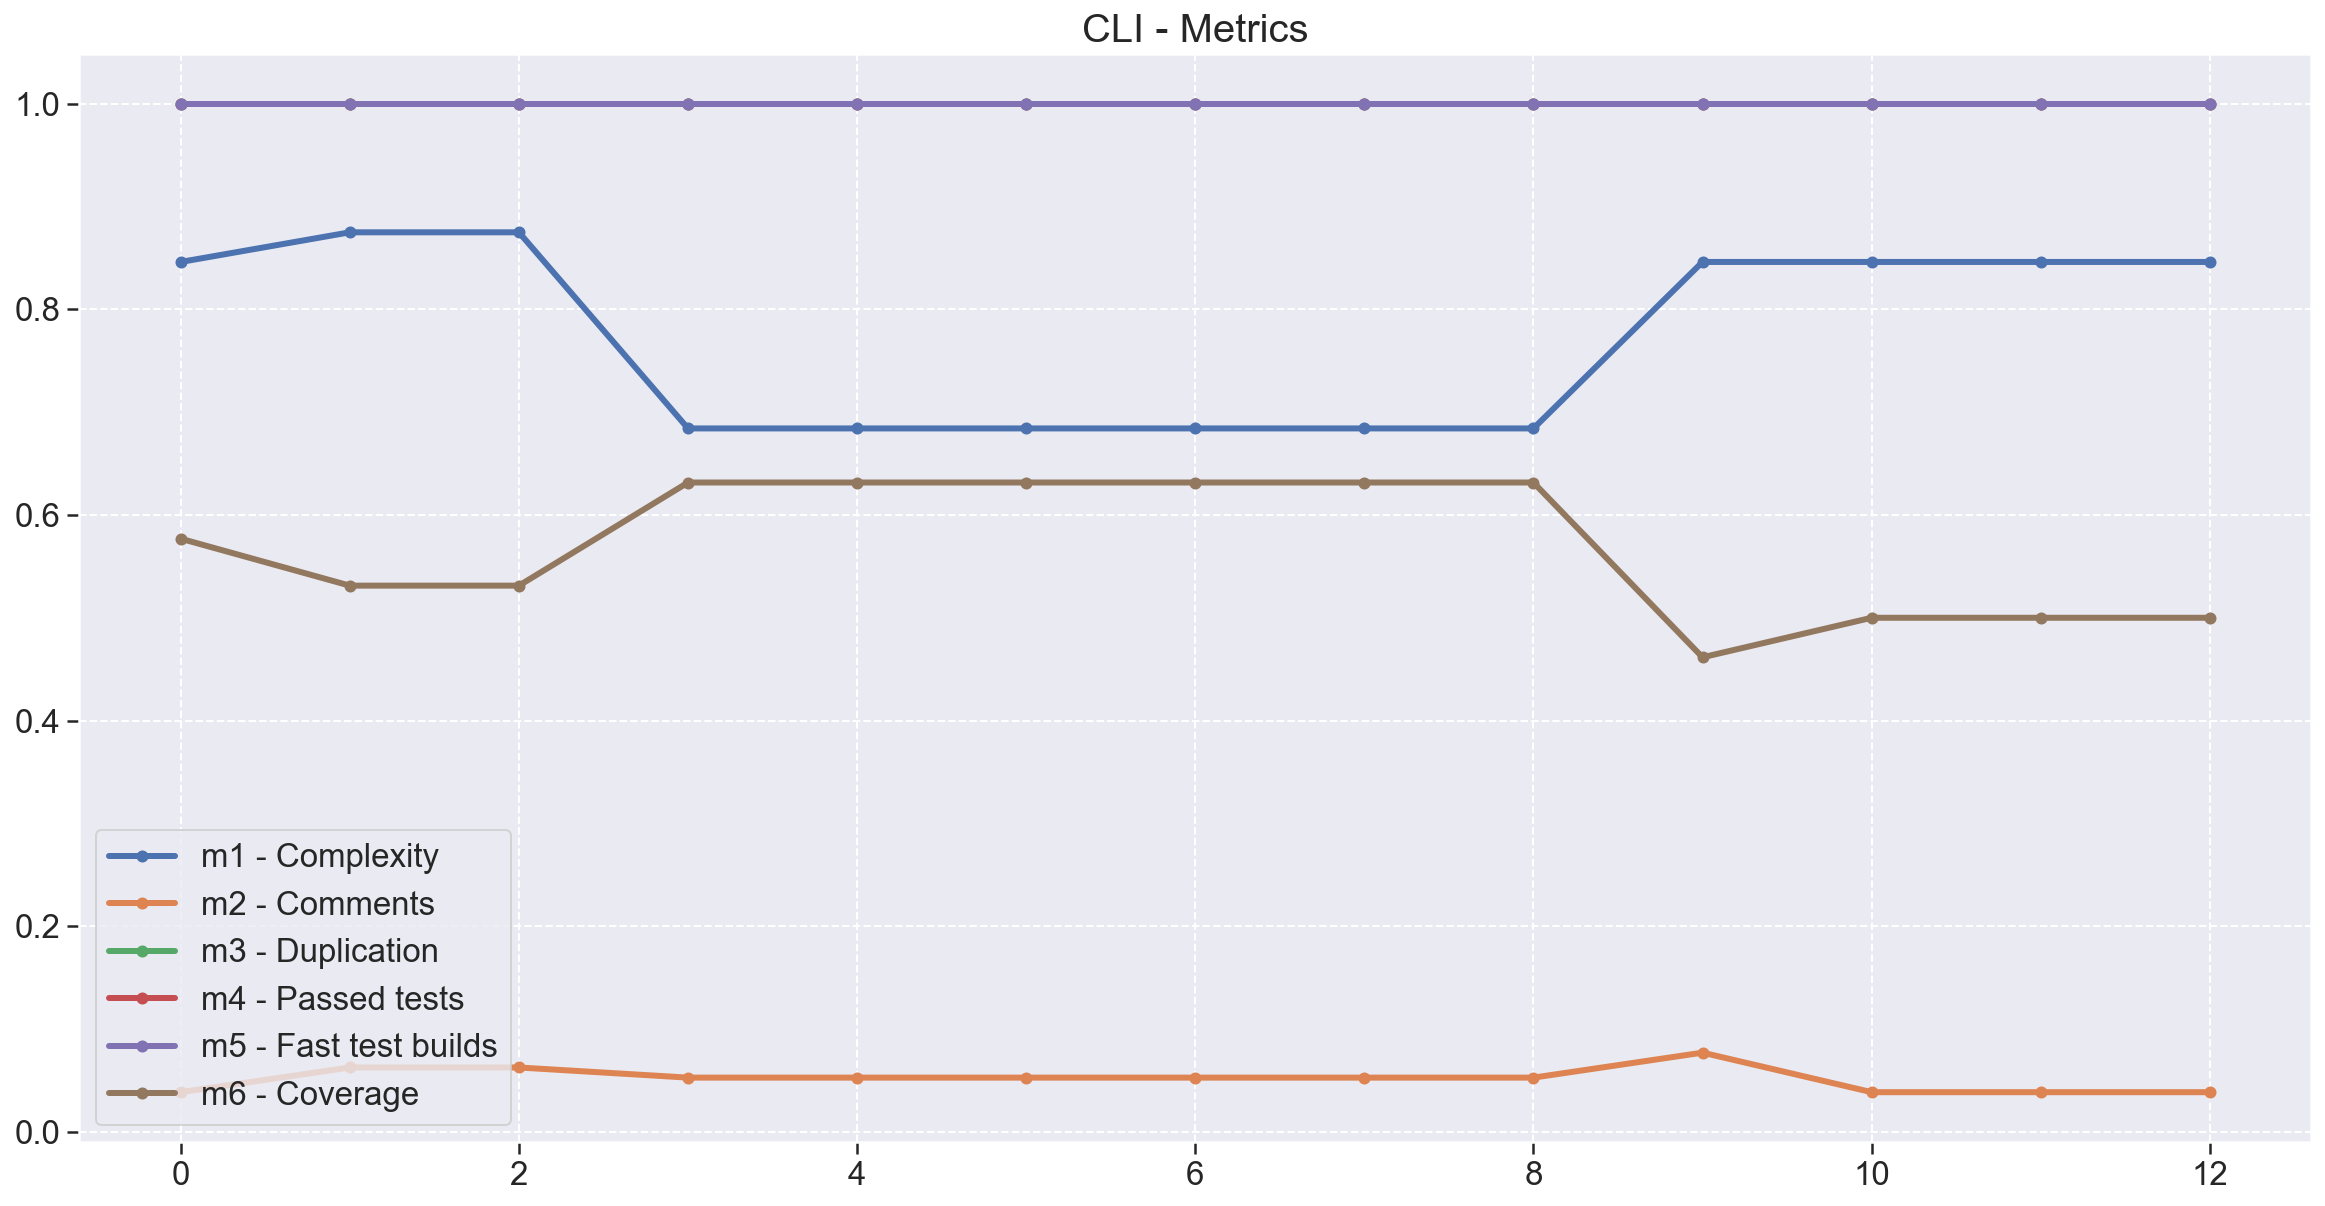

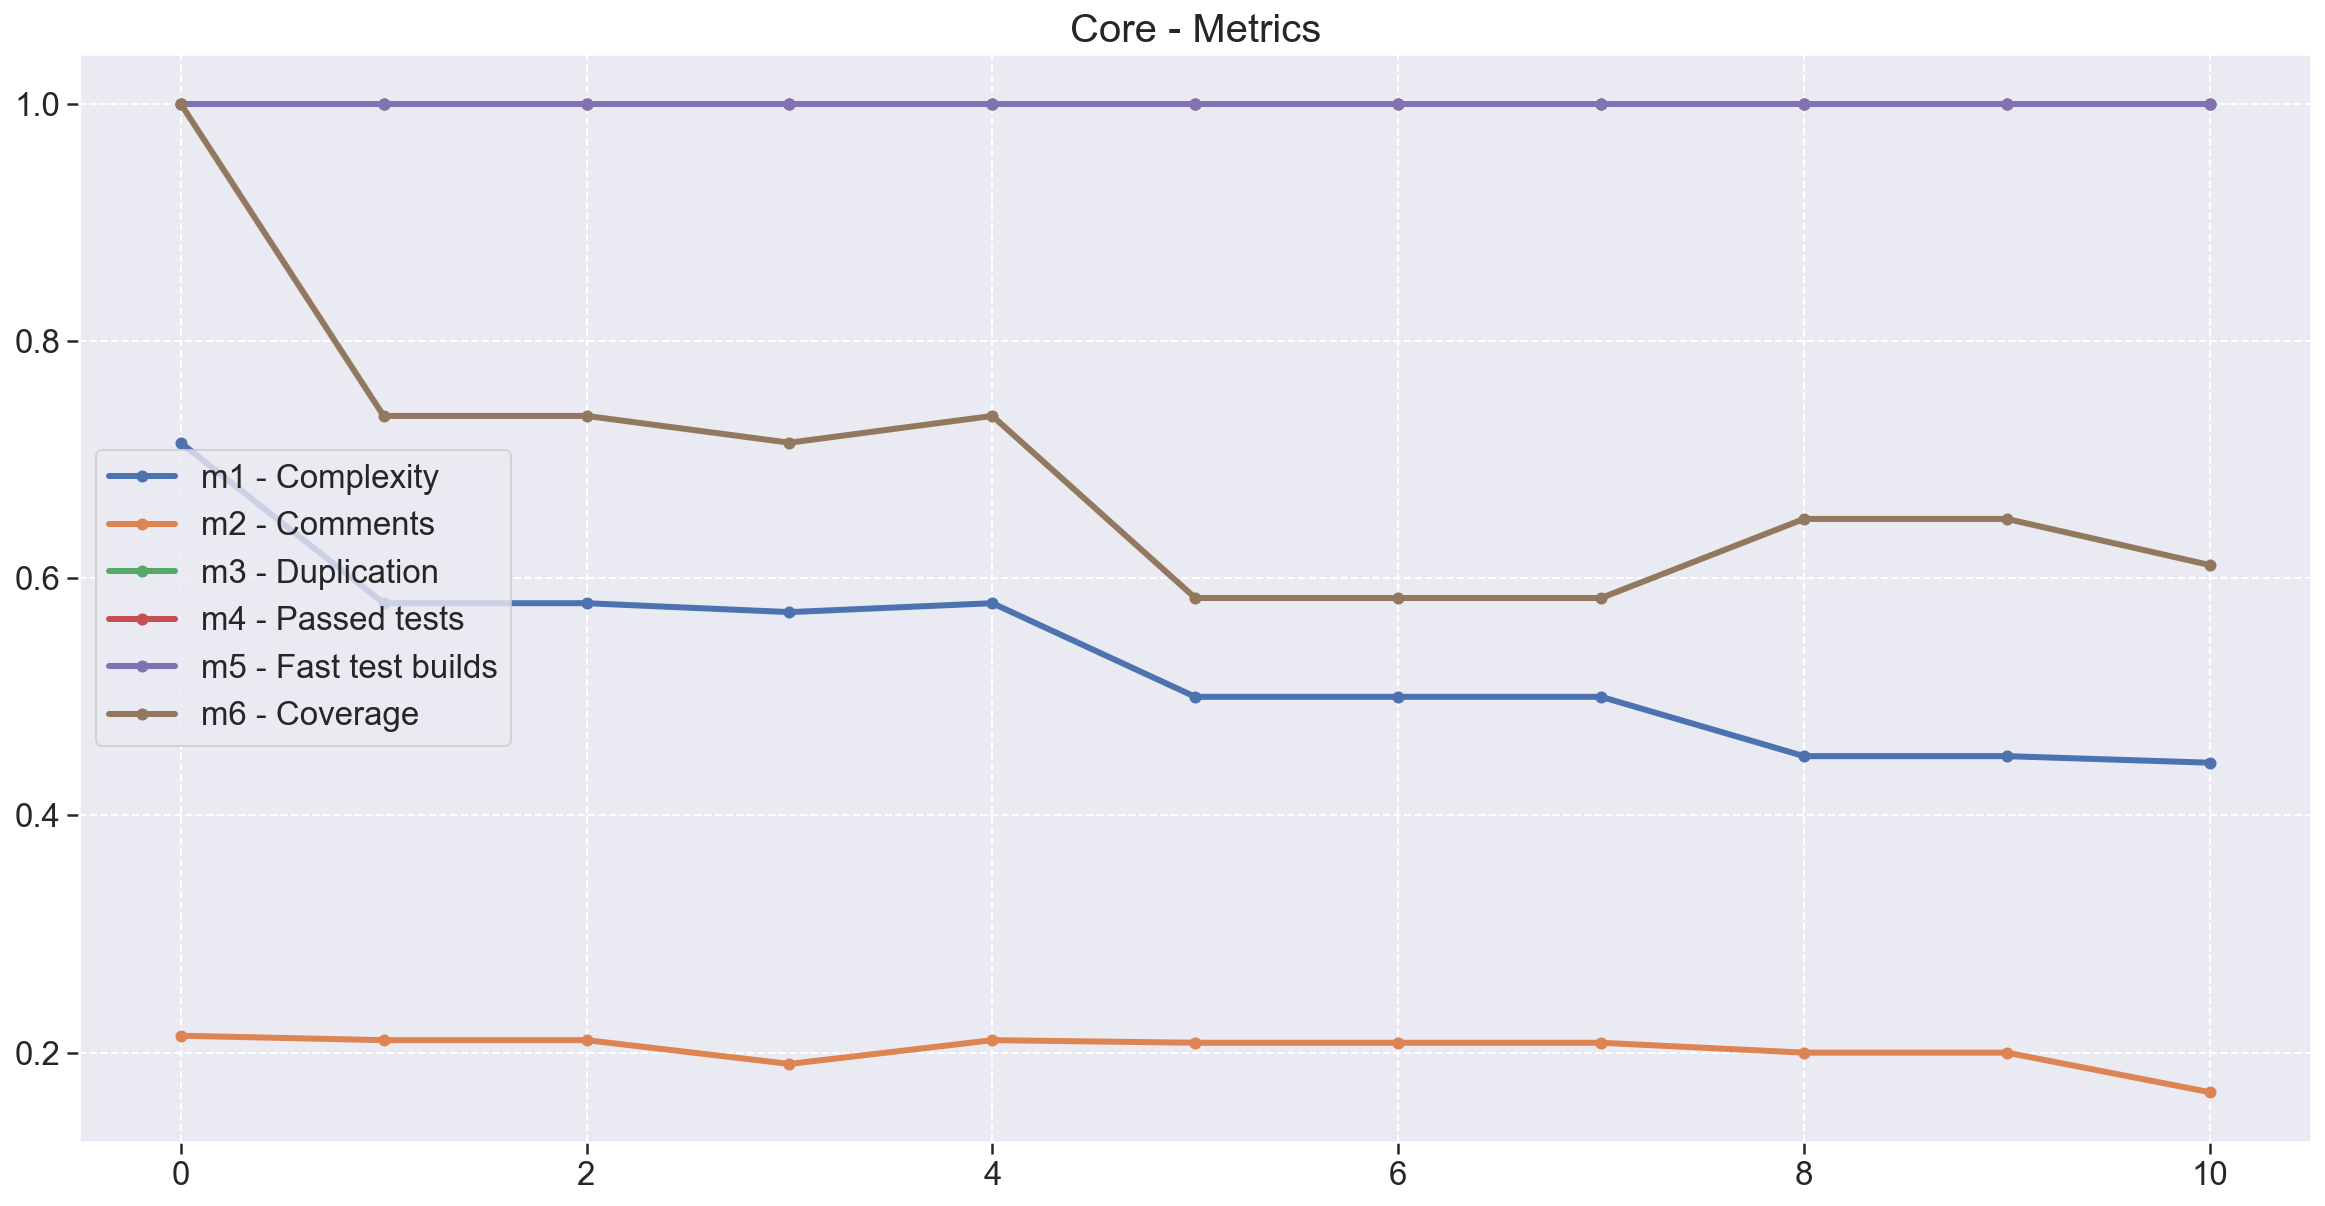

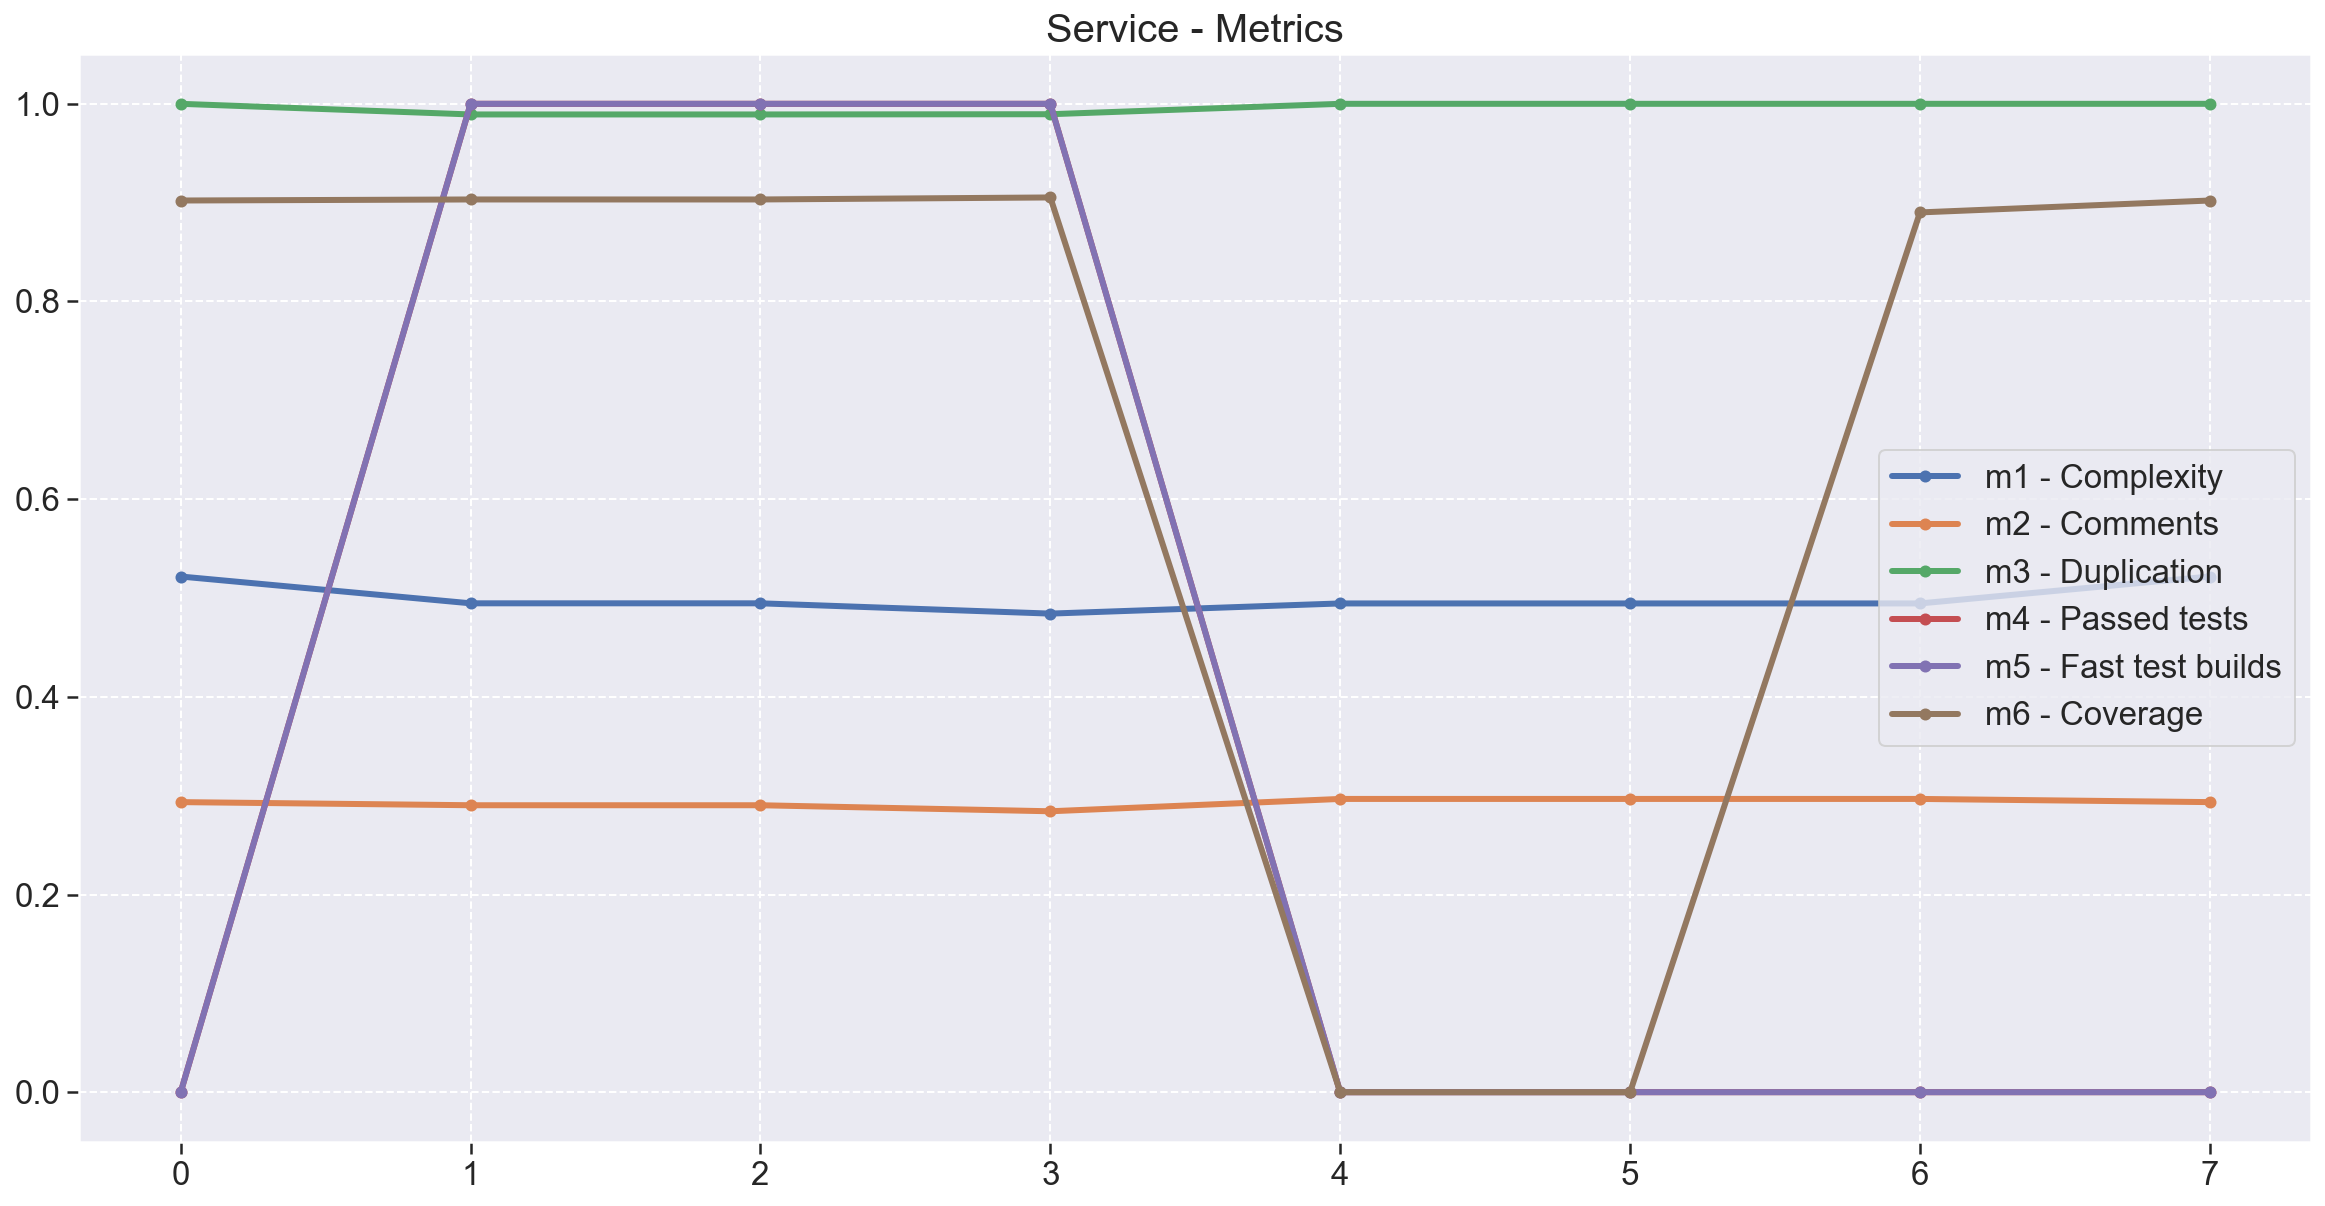

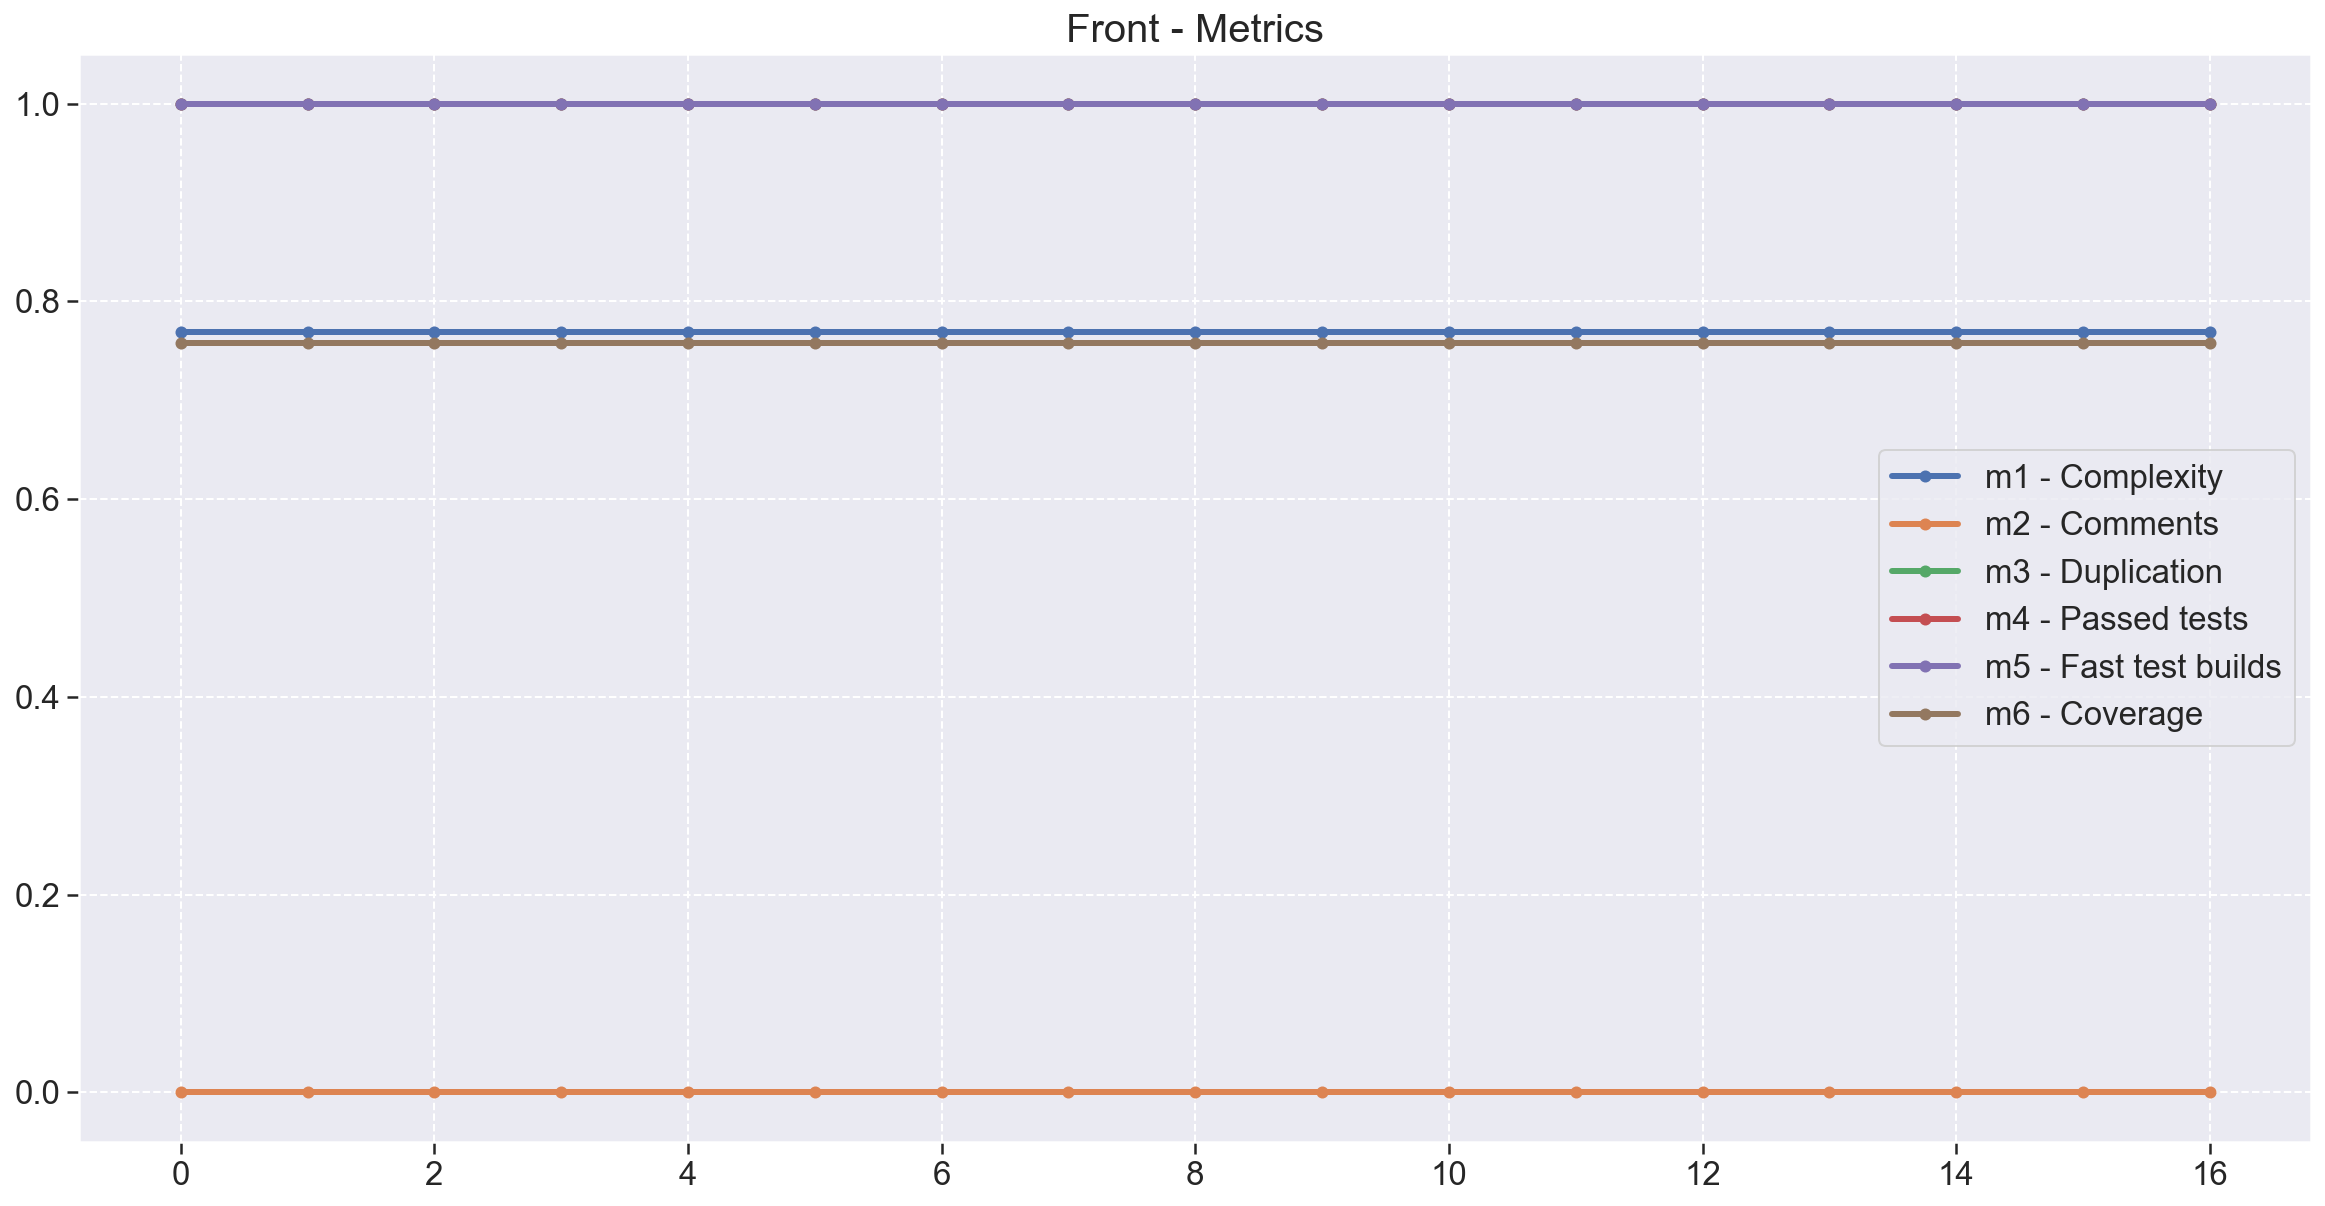

In [56]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='o', markersize=5, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='o', markersize=5, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='o', markersize=5, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='o', markersize=5, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='o', markersize=5, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='o', markersize=5, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [57]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

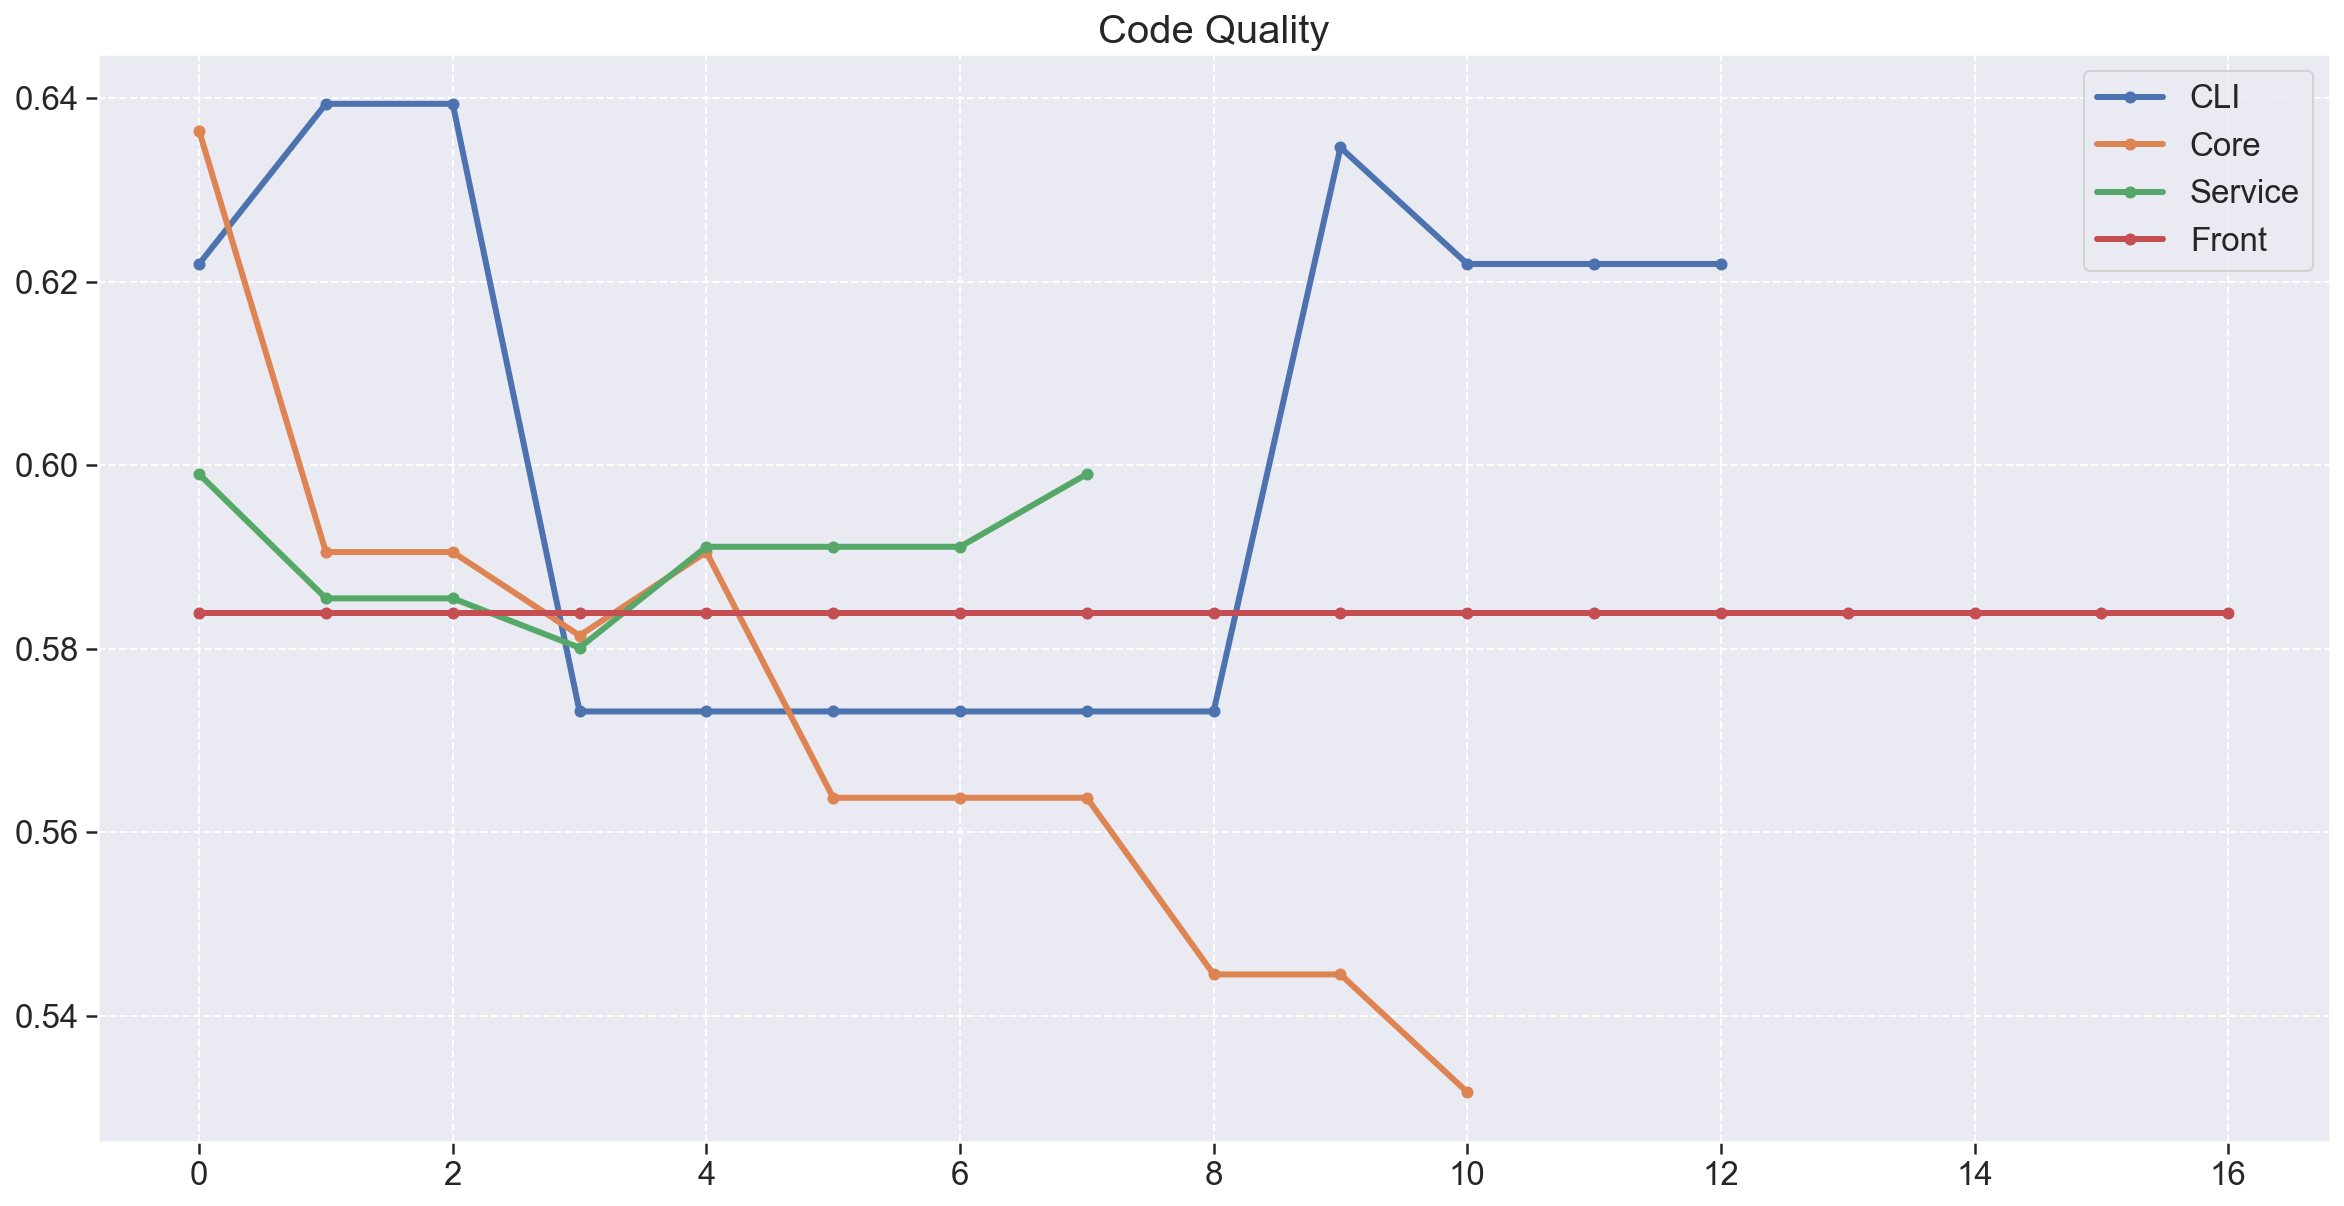

In [58]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=5, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

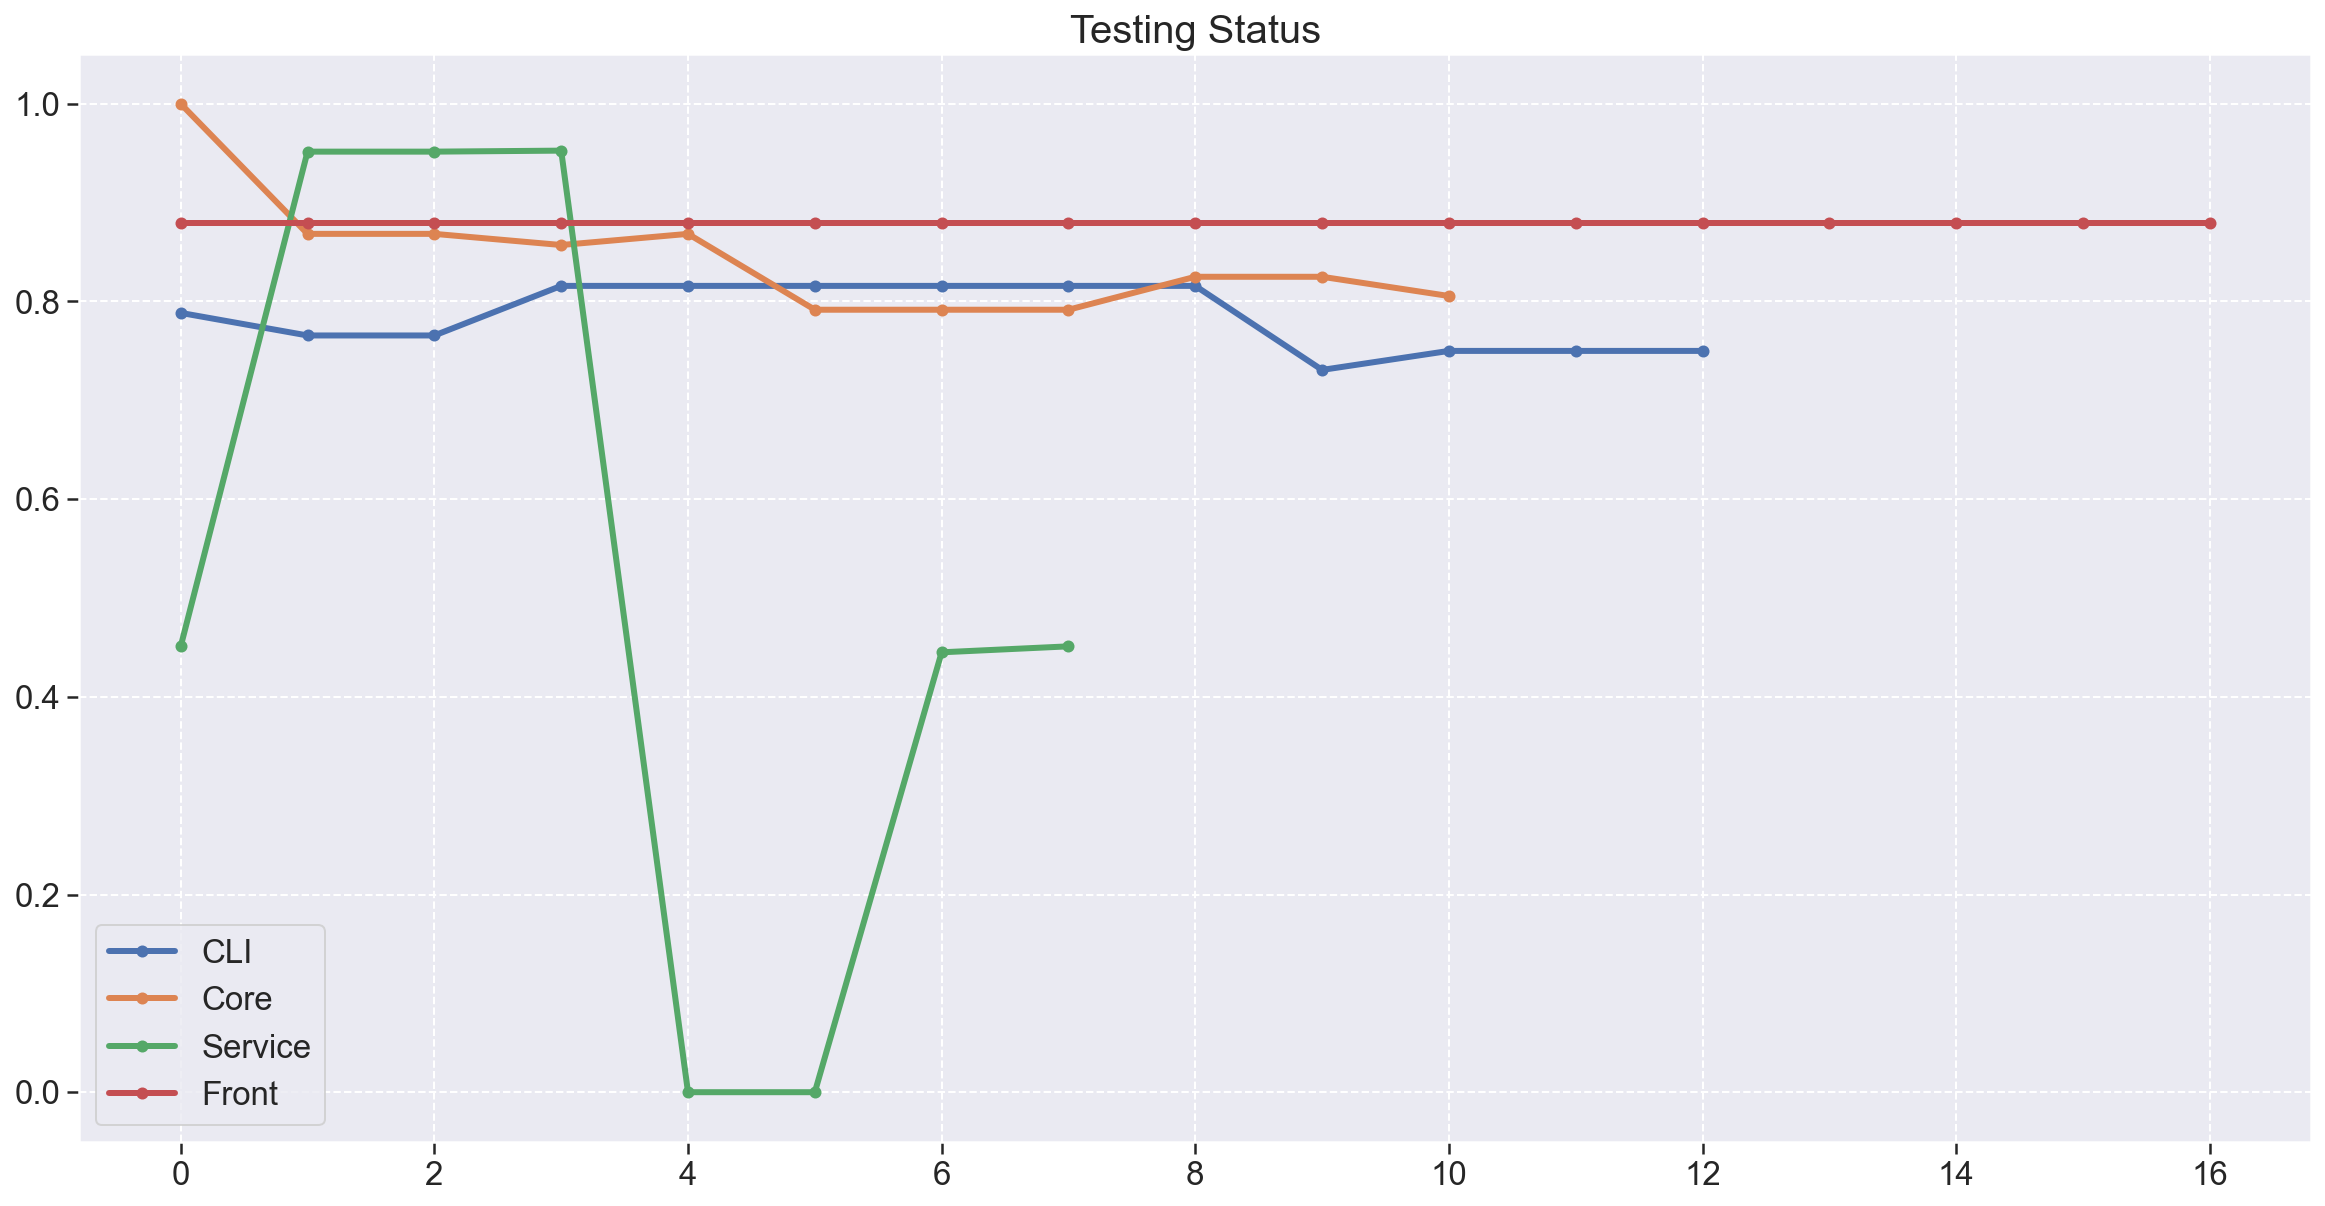

In [59]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=5, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [60]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [61]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [62]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=5, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

CLI
Maintainability Stats
    mean     mode   median      std      var      min      max
0.301539 0.286579 0.310962 0.014735 0.000217 0.286579 0.319688
Reliability Stats
    mean     mode   median      std      var      min      max
0.392124 0.407895 0.394231 0.016495 0.000272 0.365385 0.407895


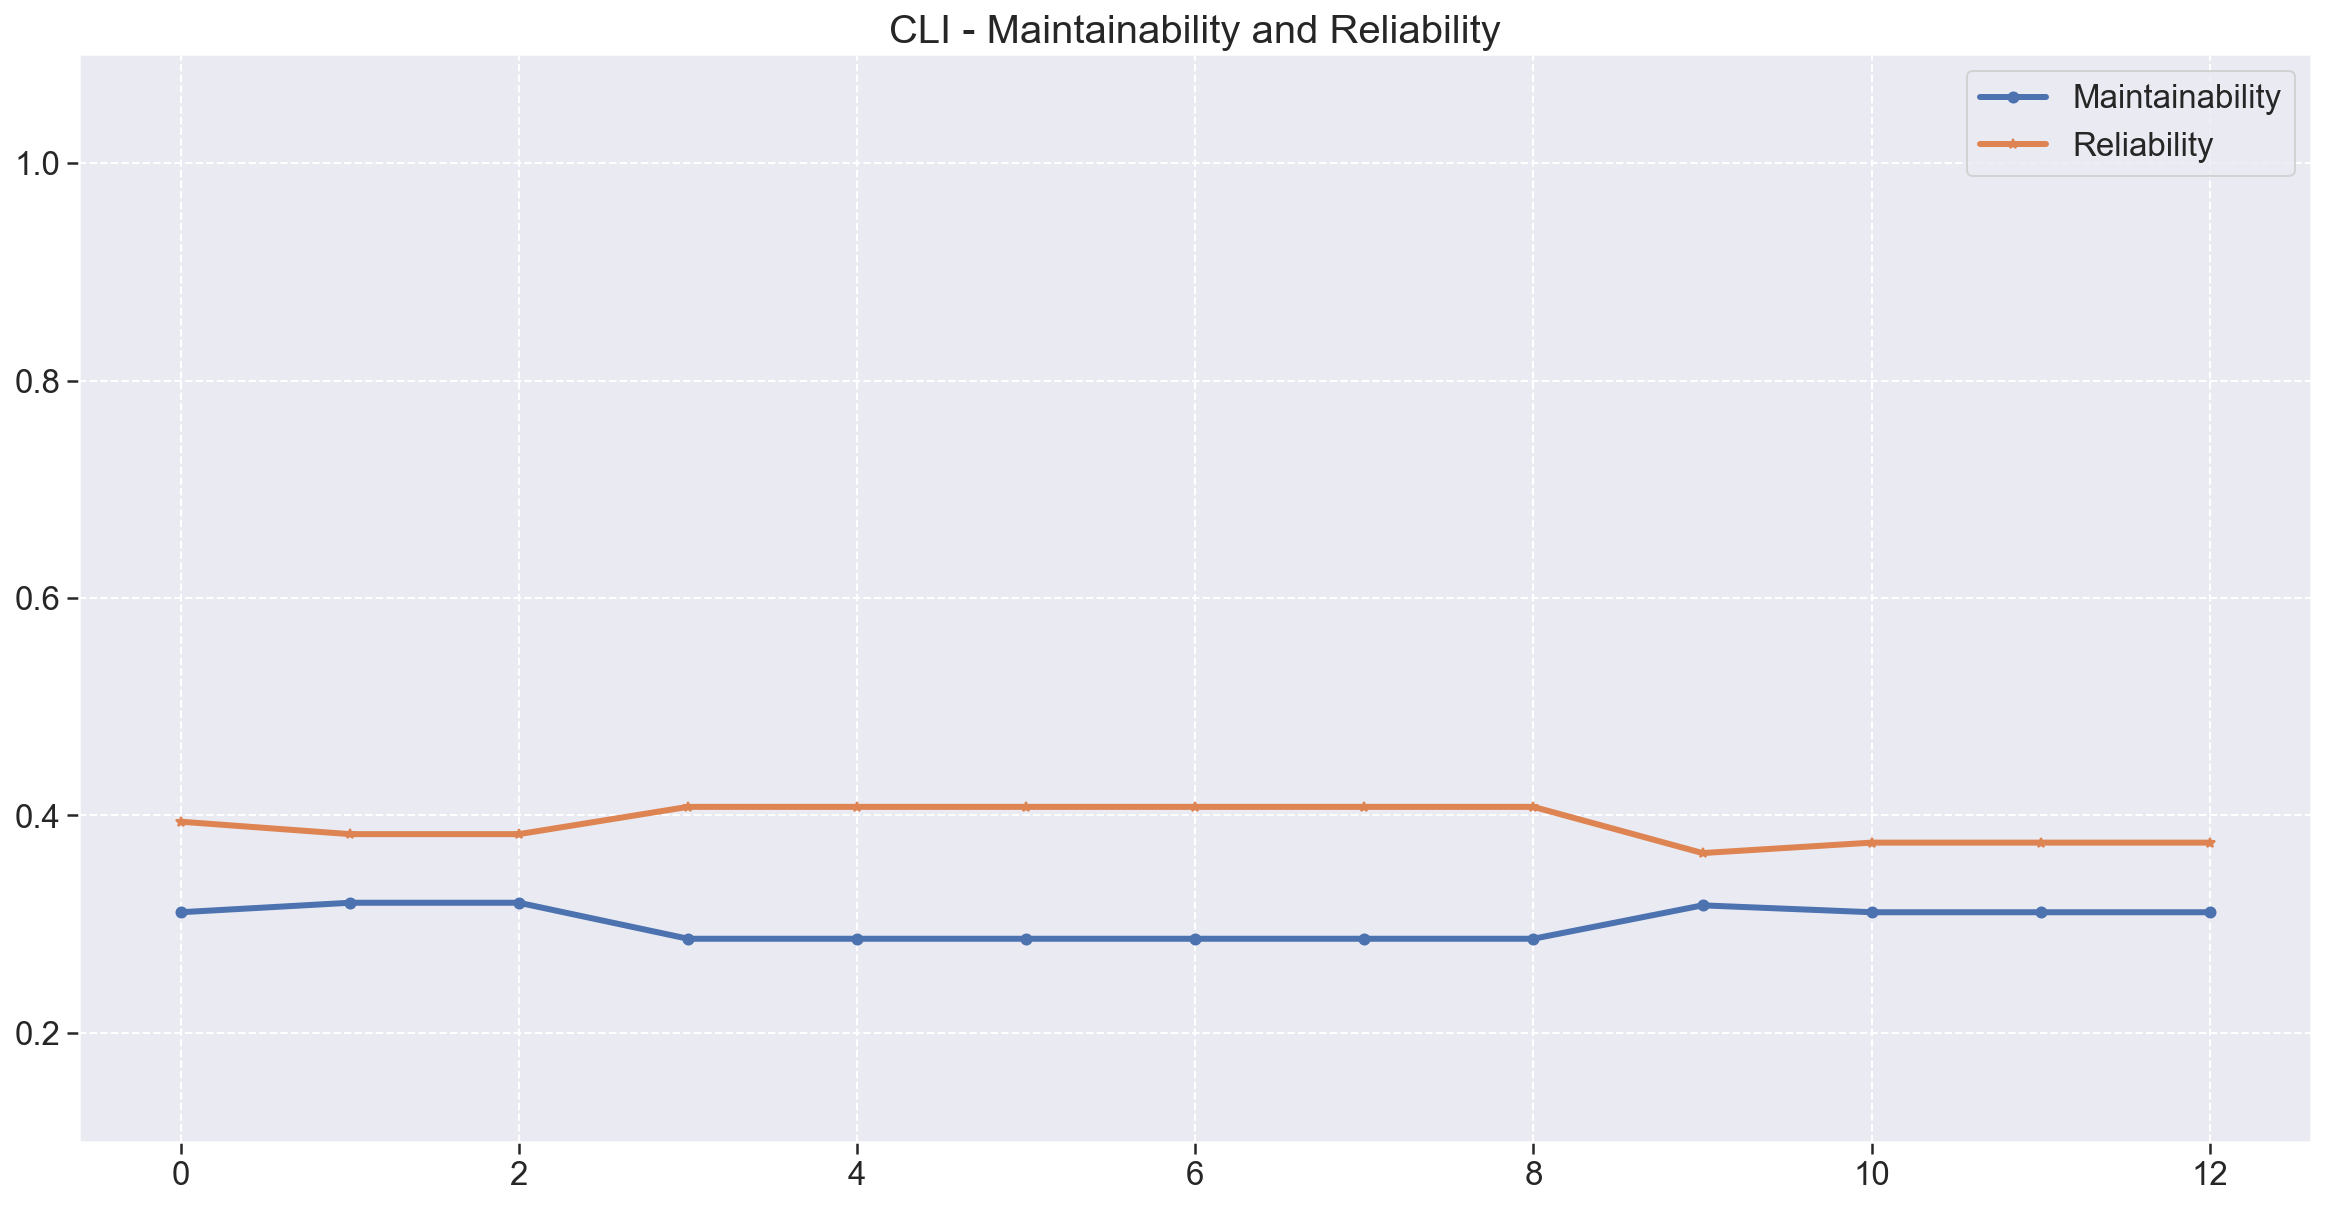

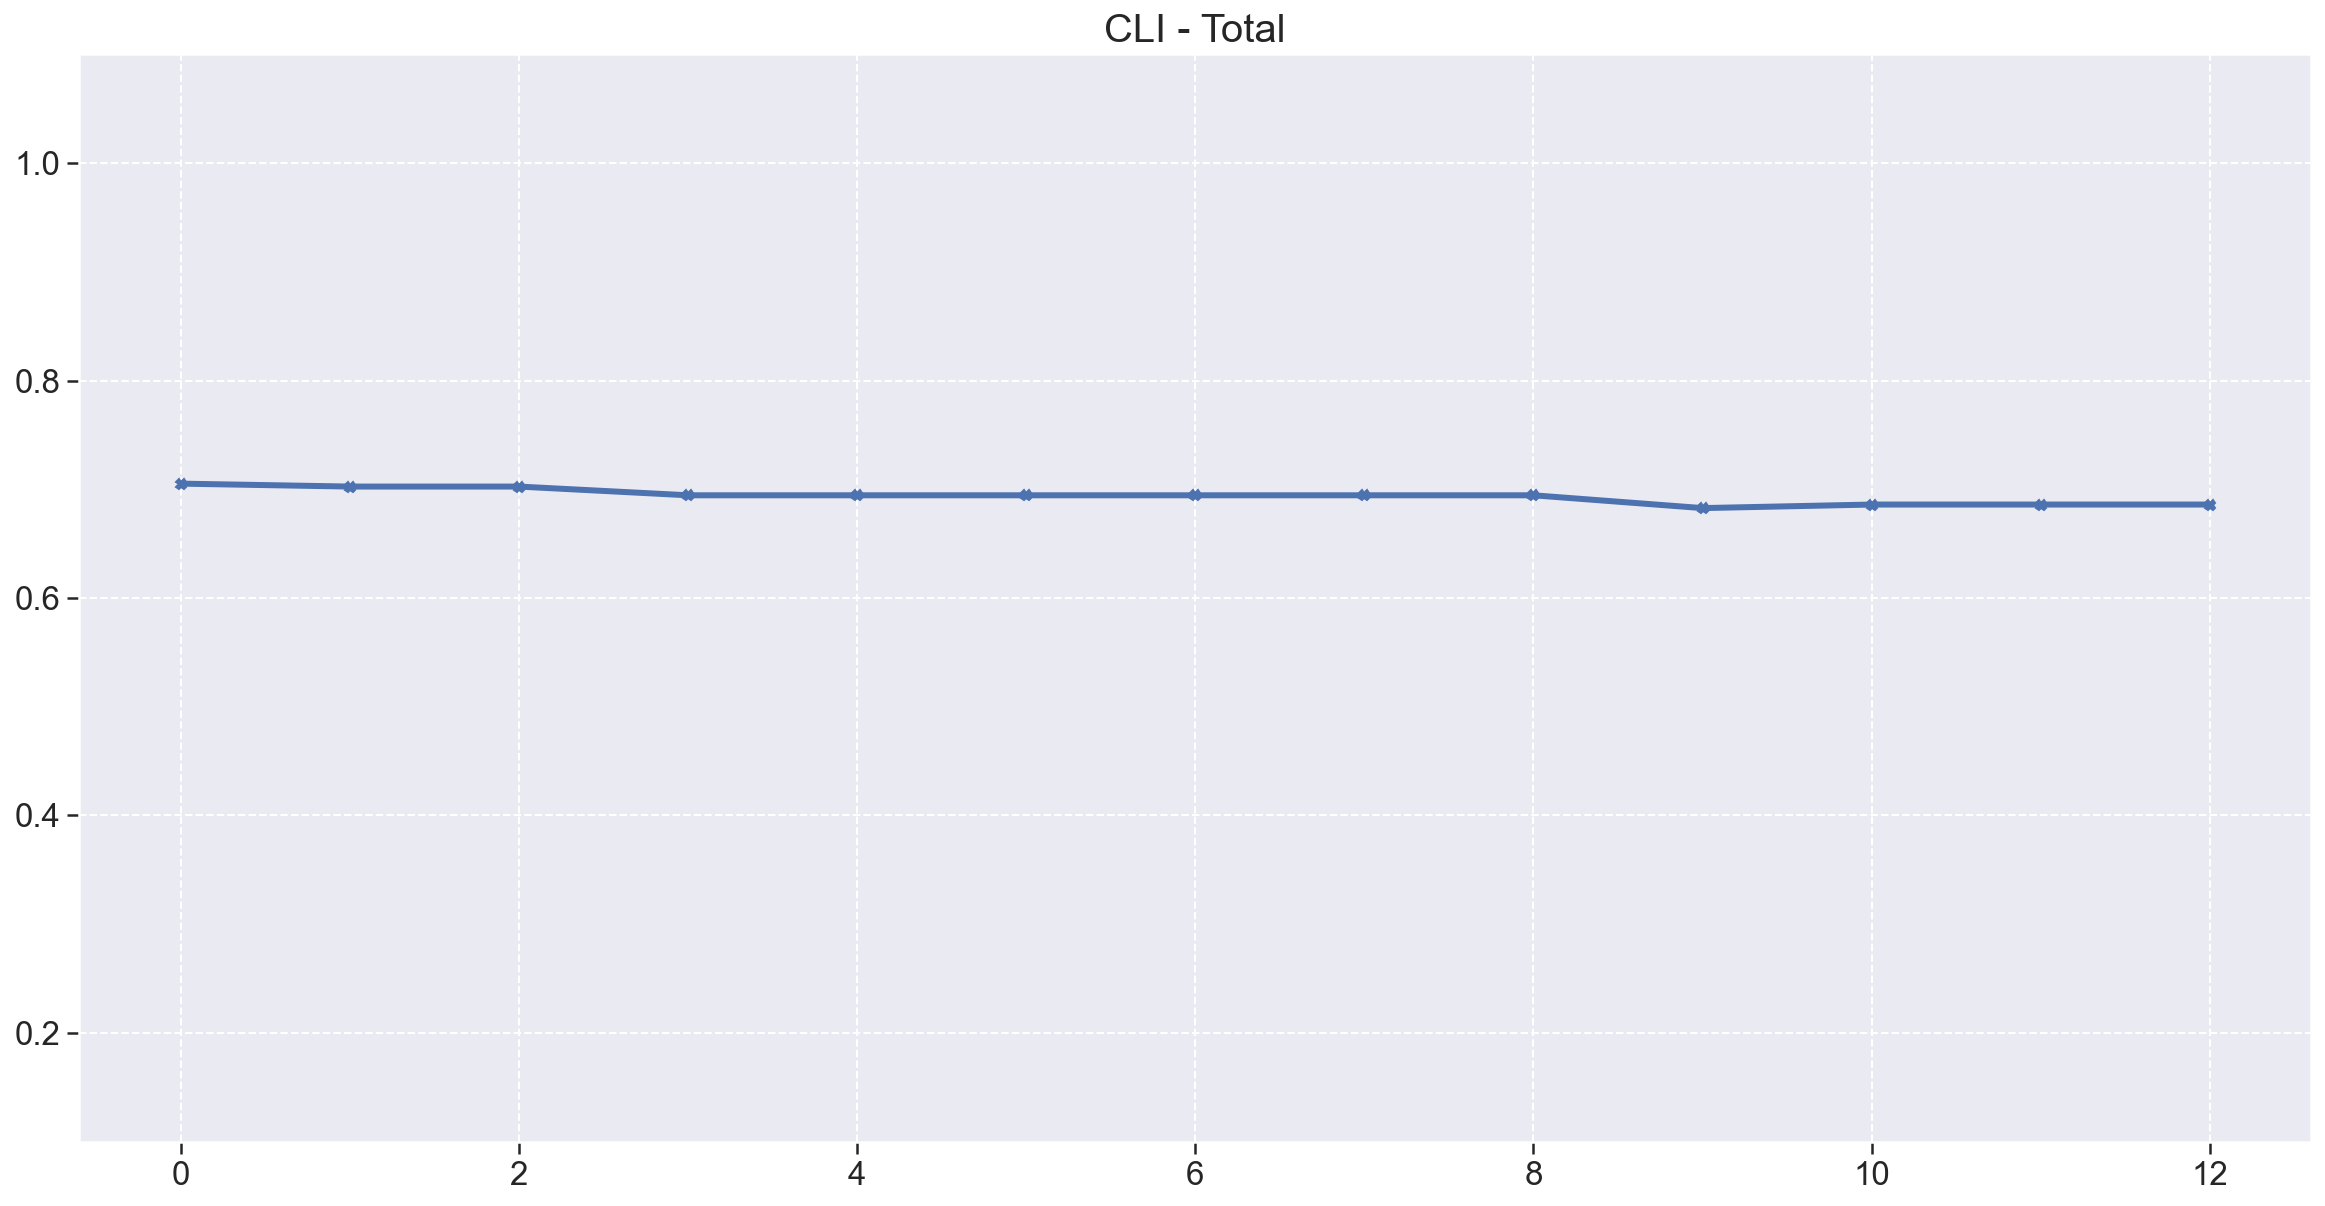

Core
Maintainability Stats
    mean     mode   median      std      var      min      max
0.286425 0.281875 0.281875 0.014667 0.000215 0.265833 0.318214
0.286425 0.295263 0.281875 0.014667 0.000215 0.265833 0.318214
Reliability Stats
    mean     mode  median      std      var      min  max
0.422407 0.395833  0.4125 0.030293 0.000918 0.395833  0.5
0.422407 0.434211  0.4125 0.030293 0.000918 0.395833  0.5


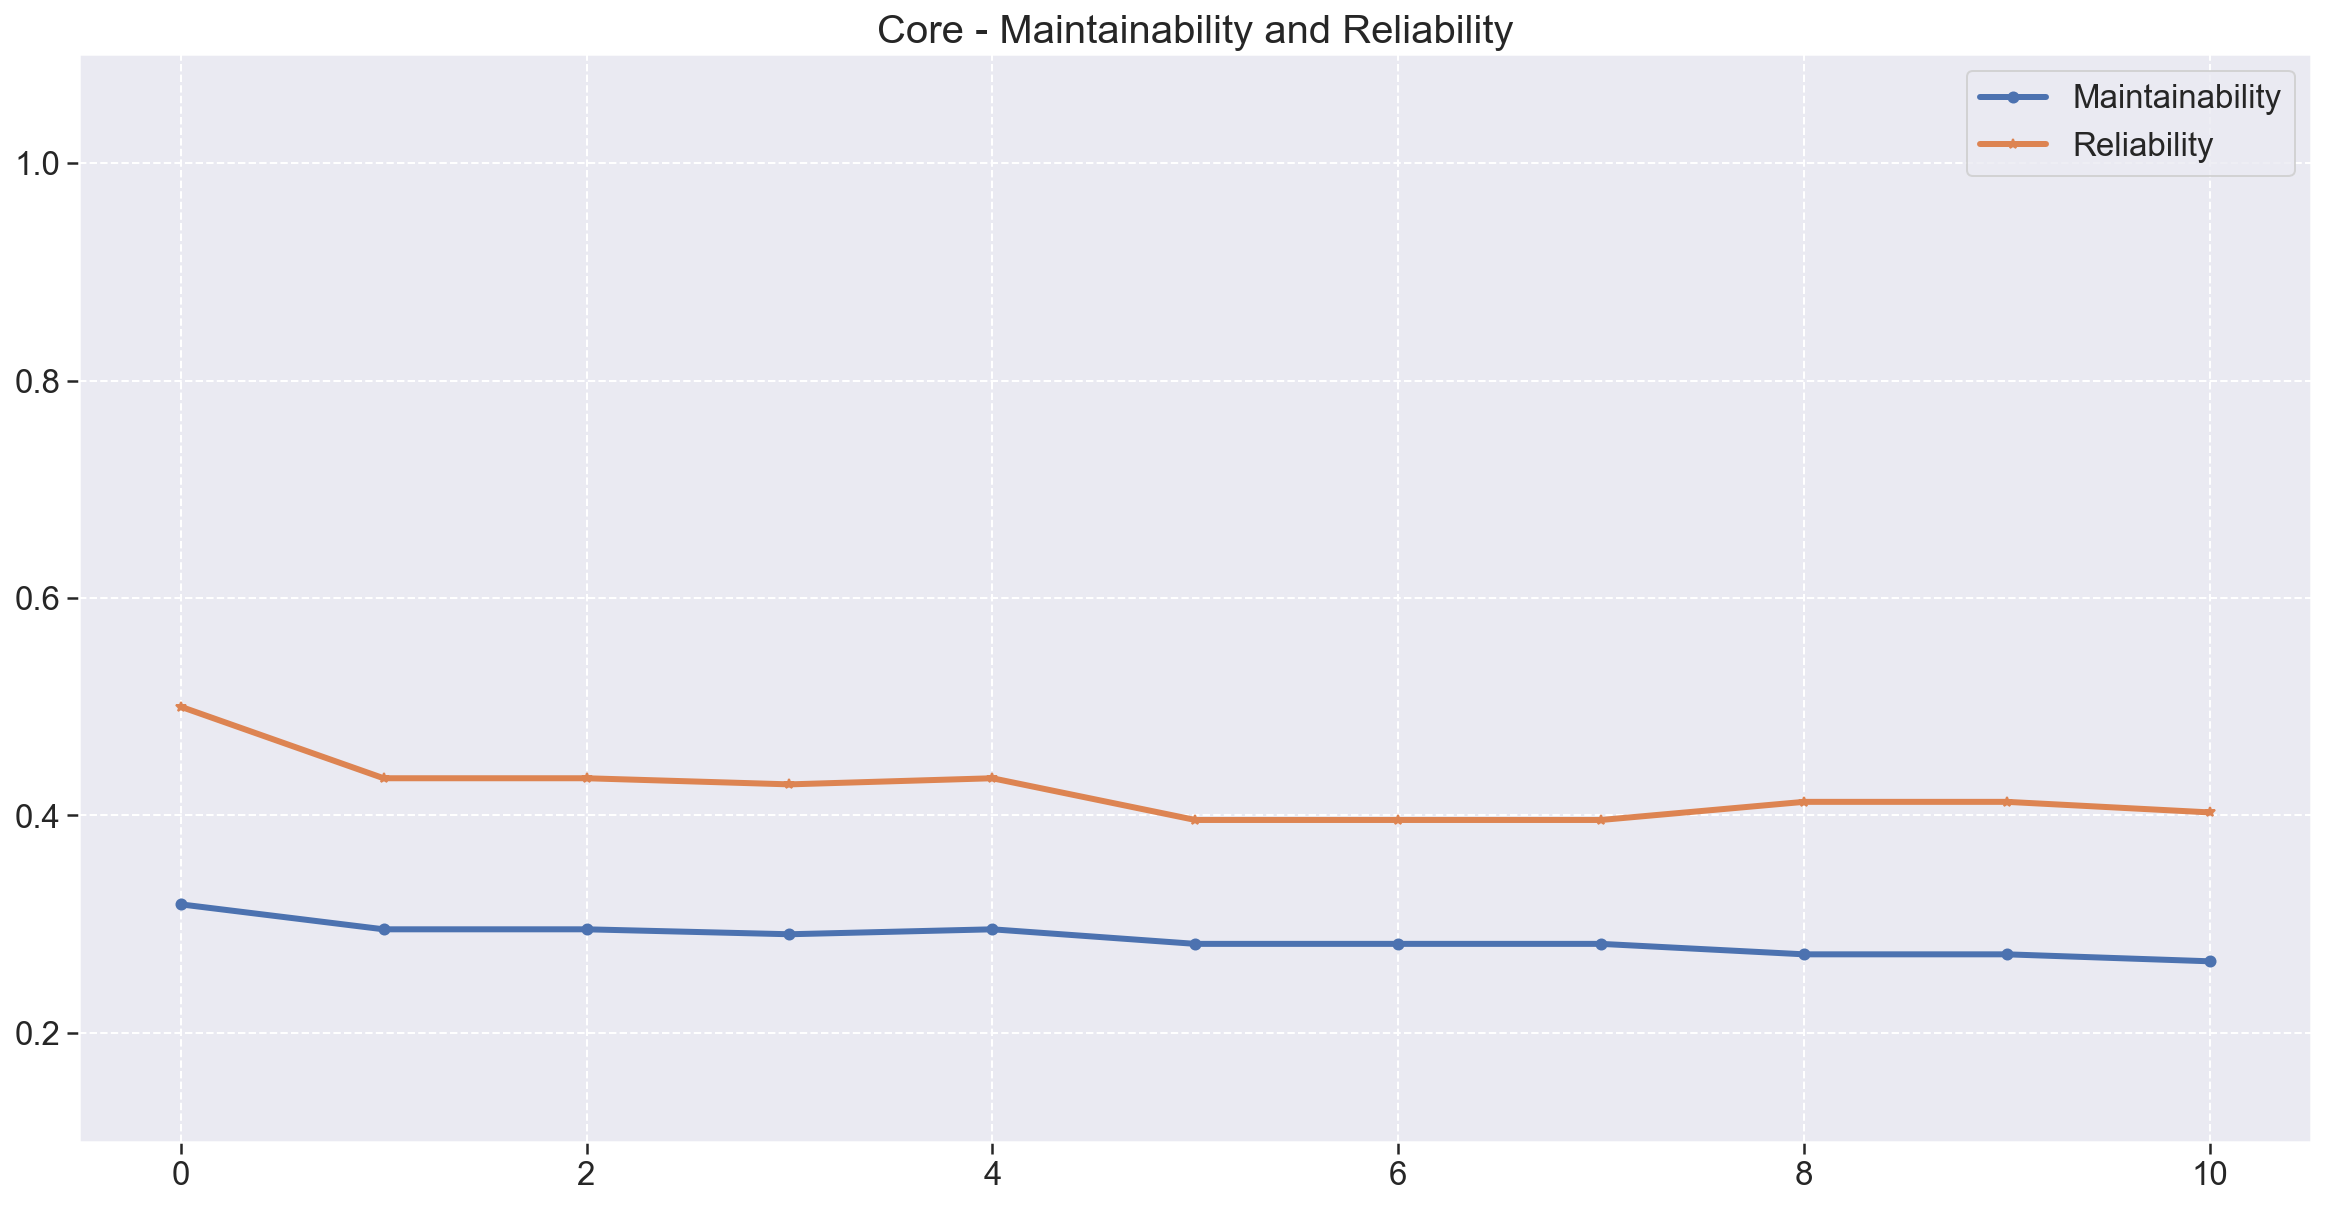

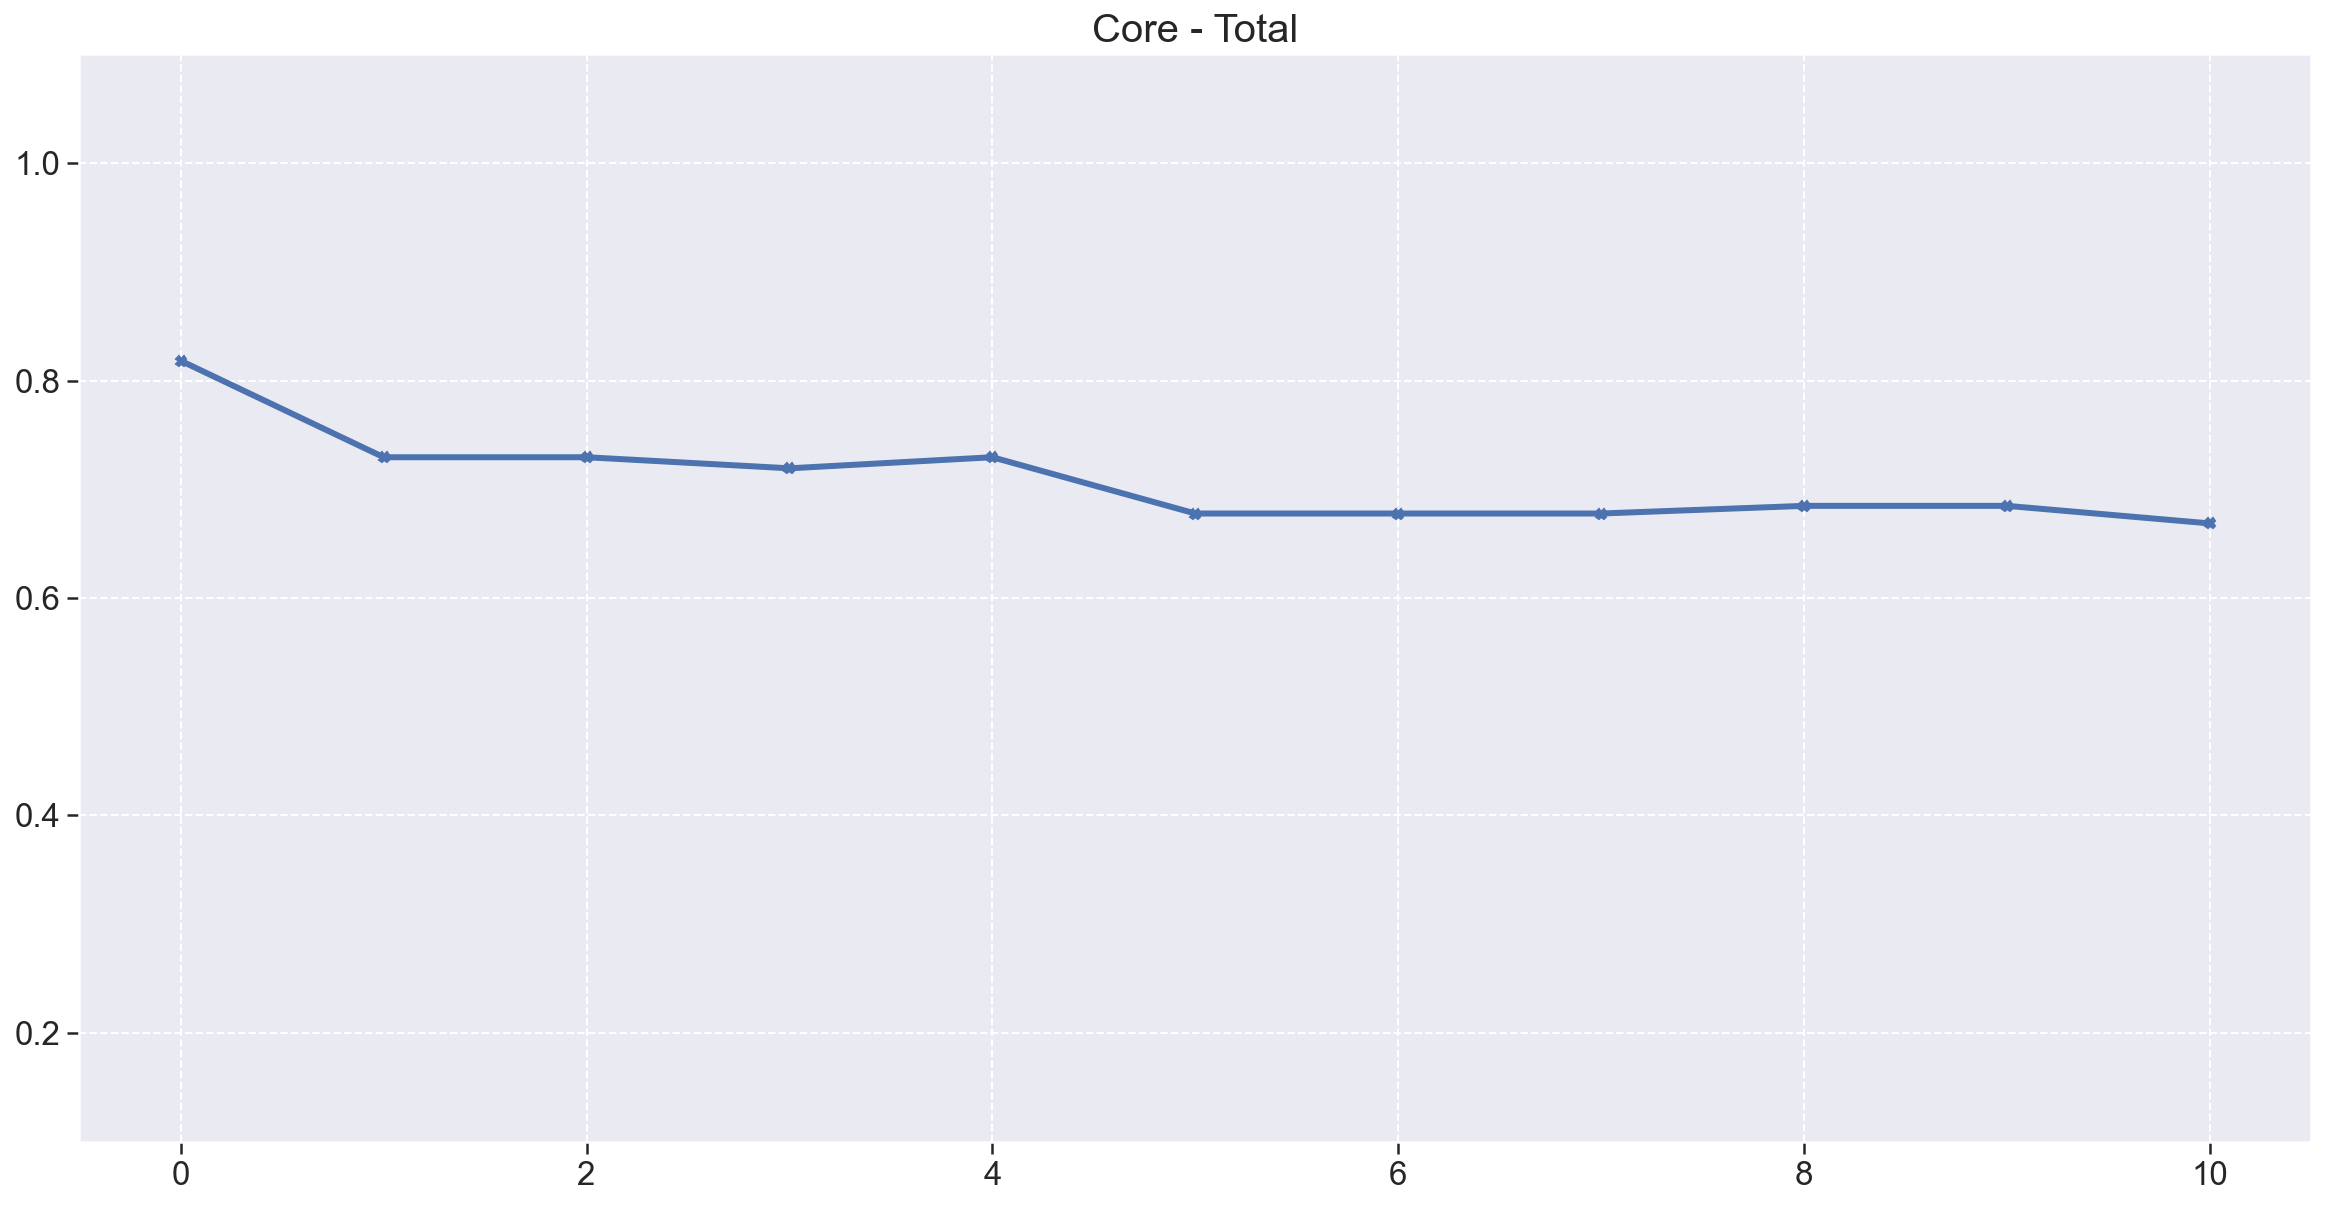

Service
Maintainability Stats
    mean     mode   median      std      var      min      max
0.295151 0.295549 0.295549 0.003297 0.000011 0.290053 0.299511
Reliability Stats
    mean     mode   median      std      var  min      max
0.262693 0.000000 0.225543 0.199592 0.039837  0.0 0.476316
0.262693 0.225543 0.225543 0.199592 0.039837  0.0 0.476316
0.262693 0.475806 0.225543 0.199592 0.039837  0.0 0.476316


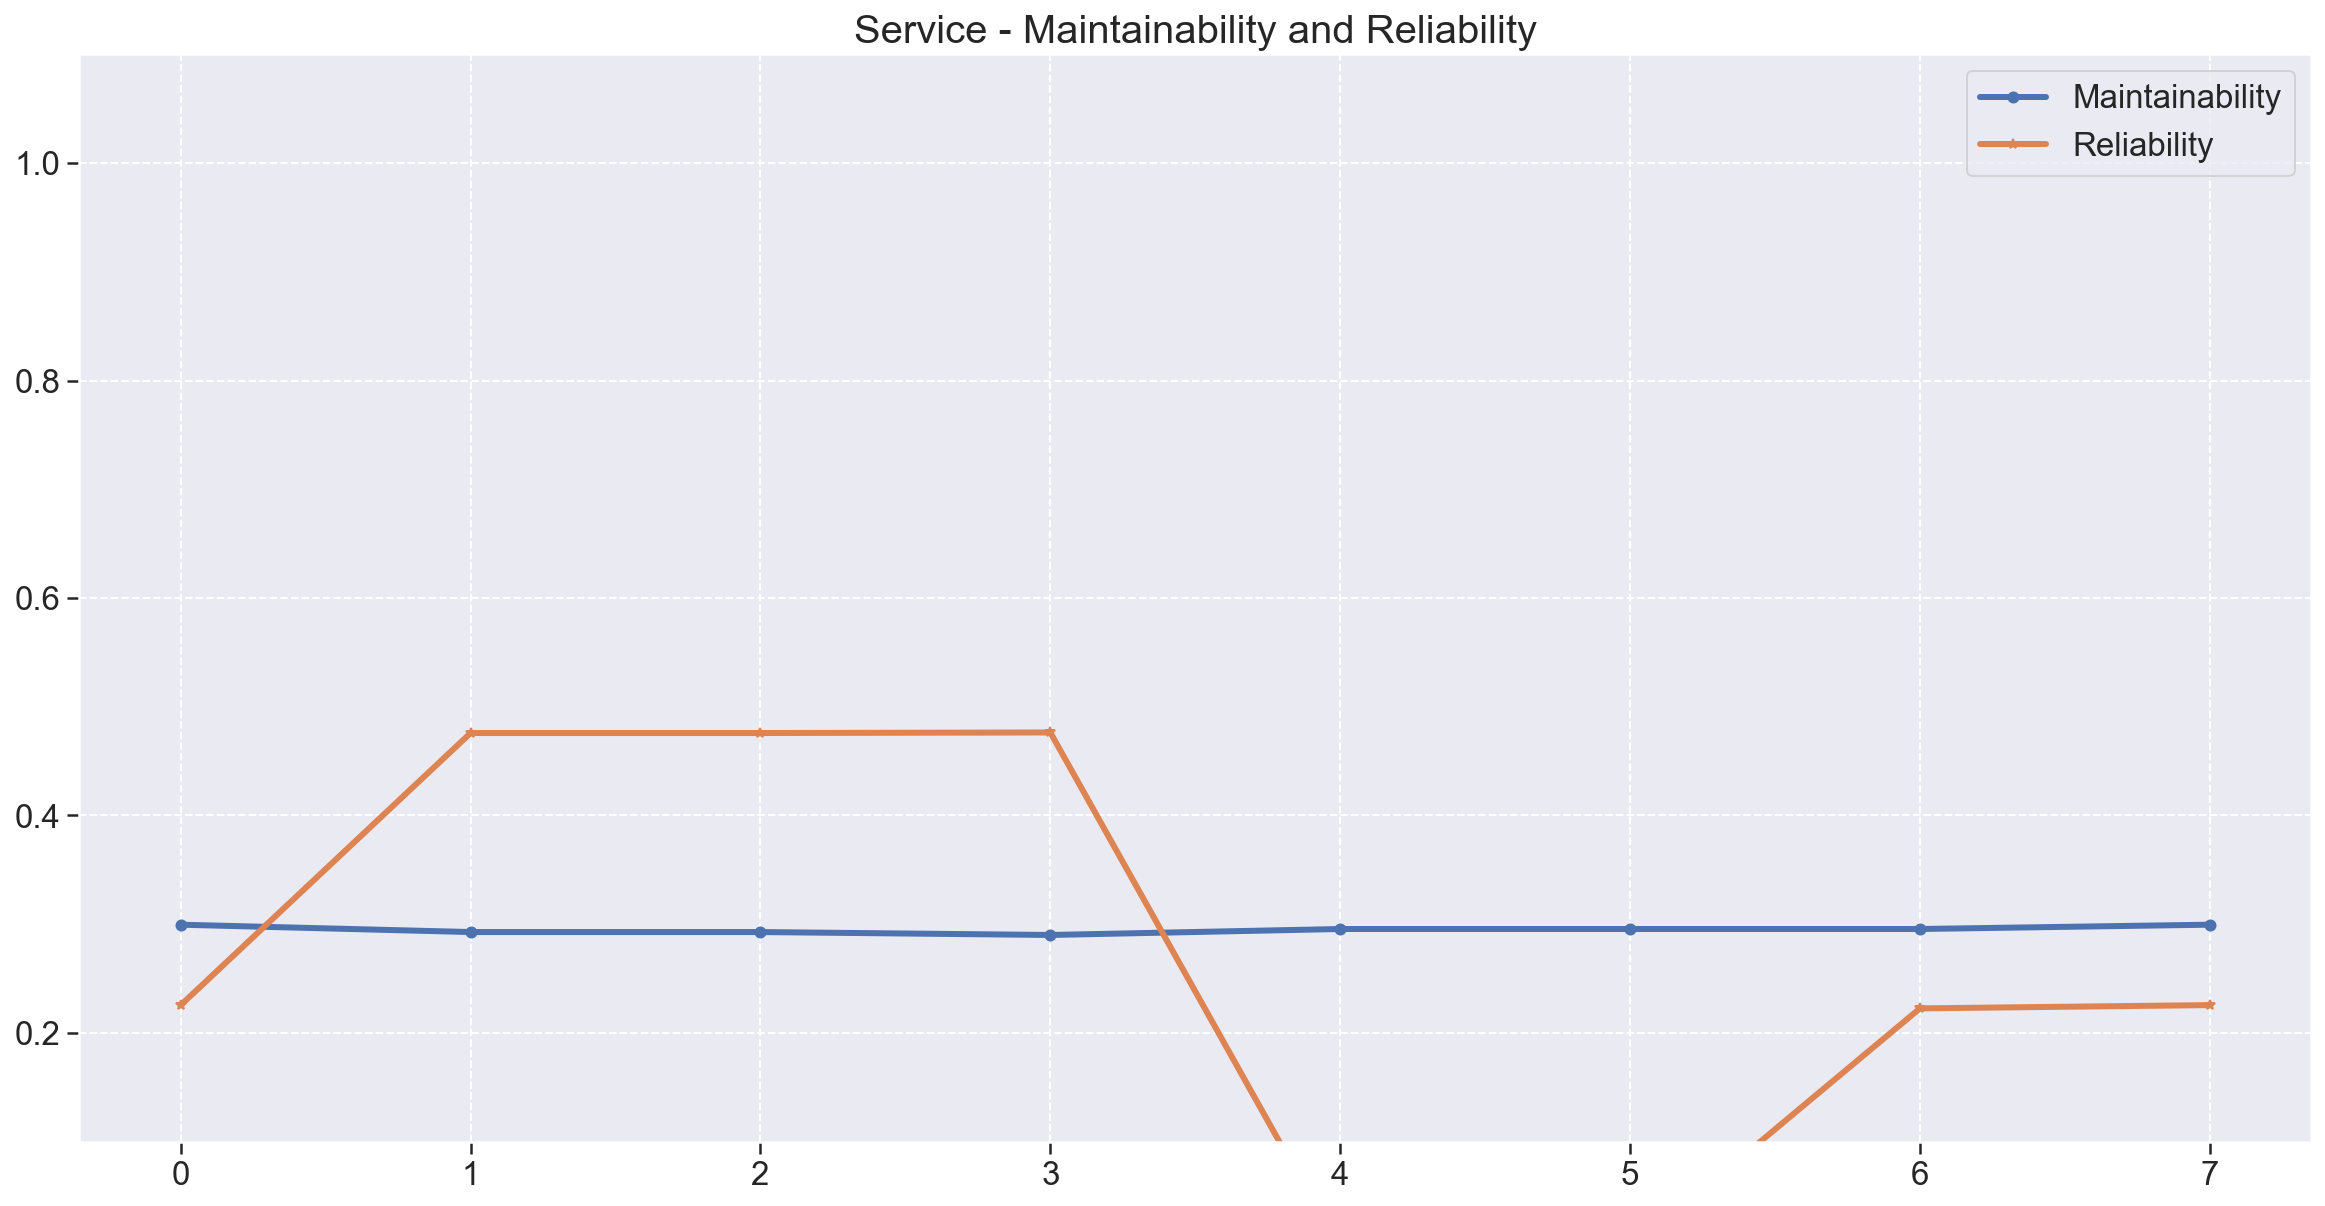

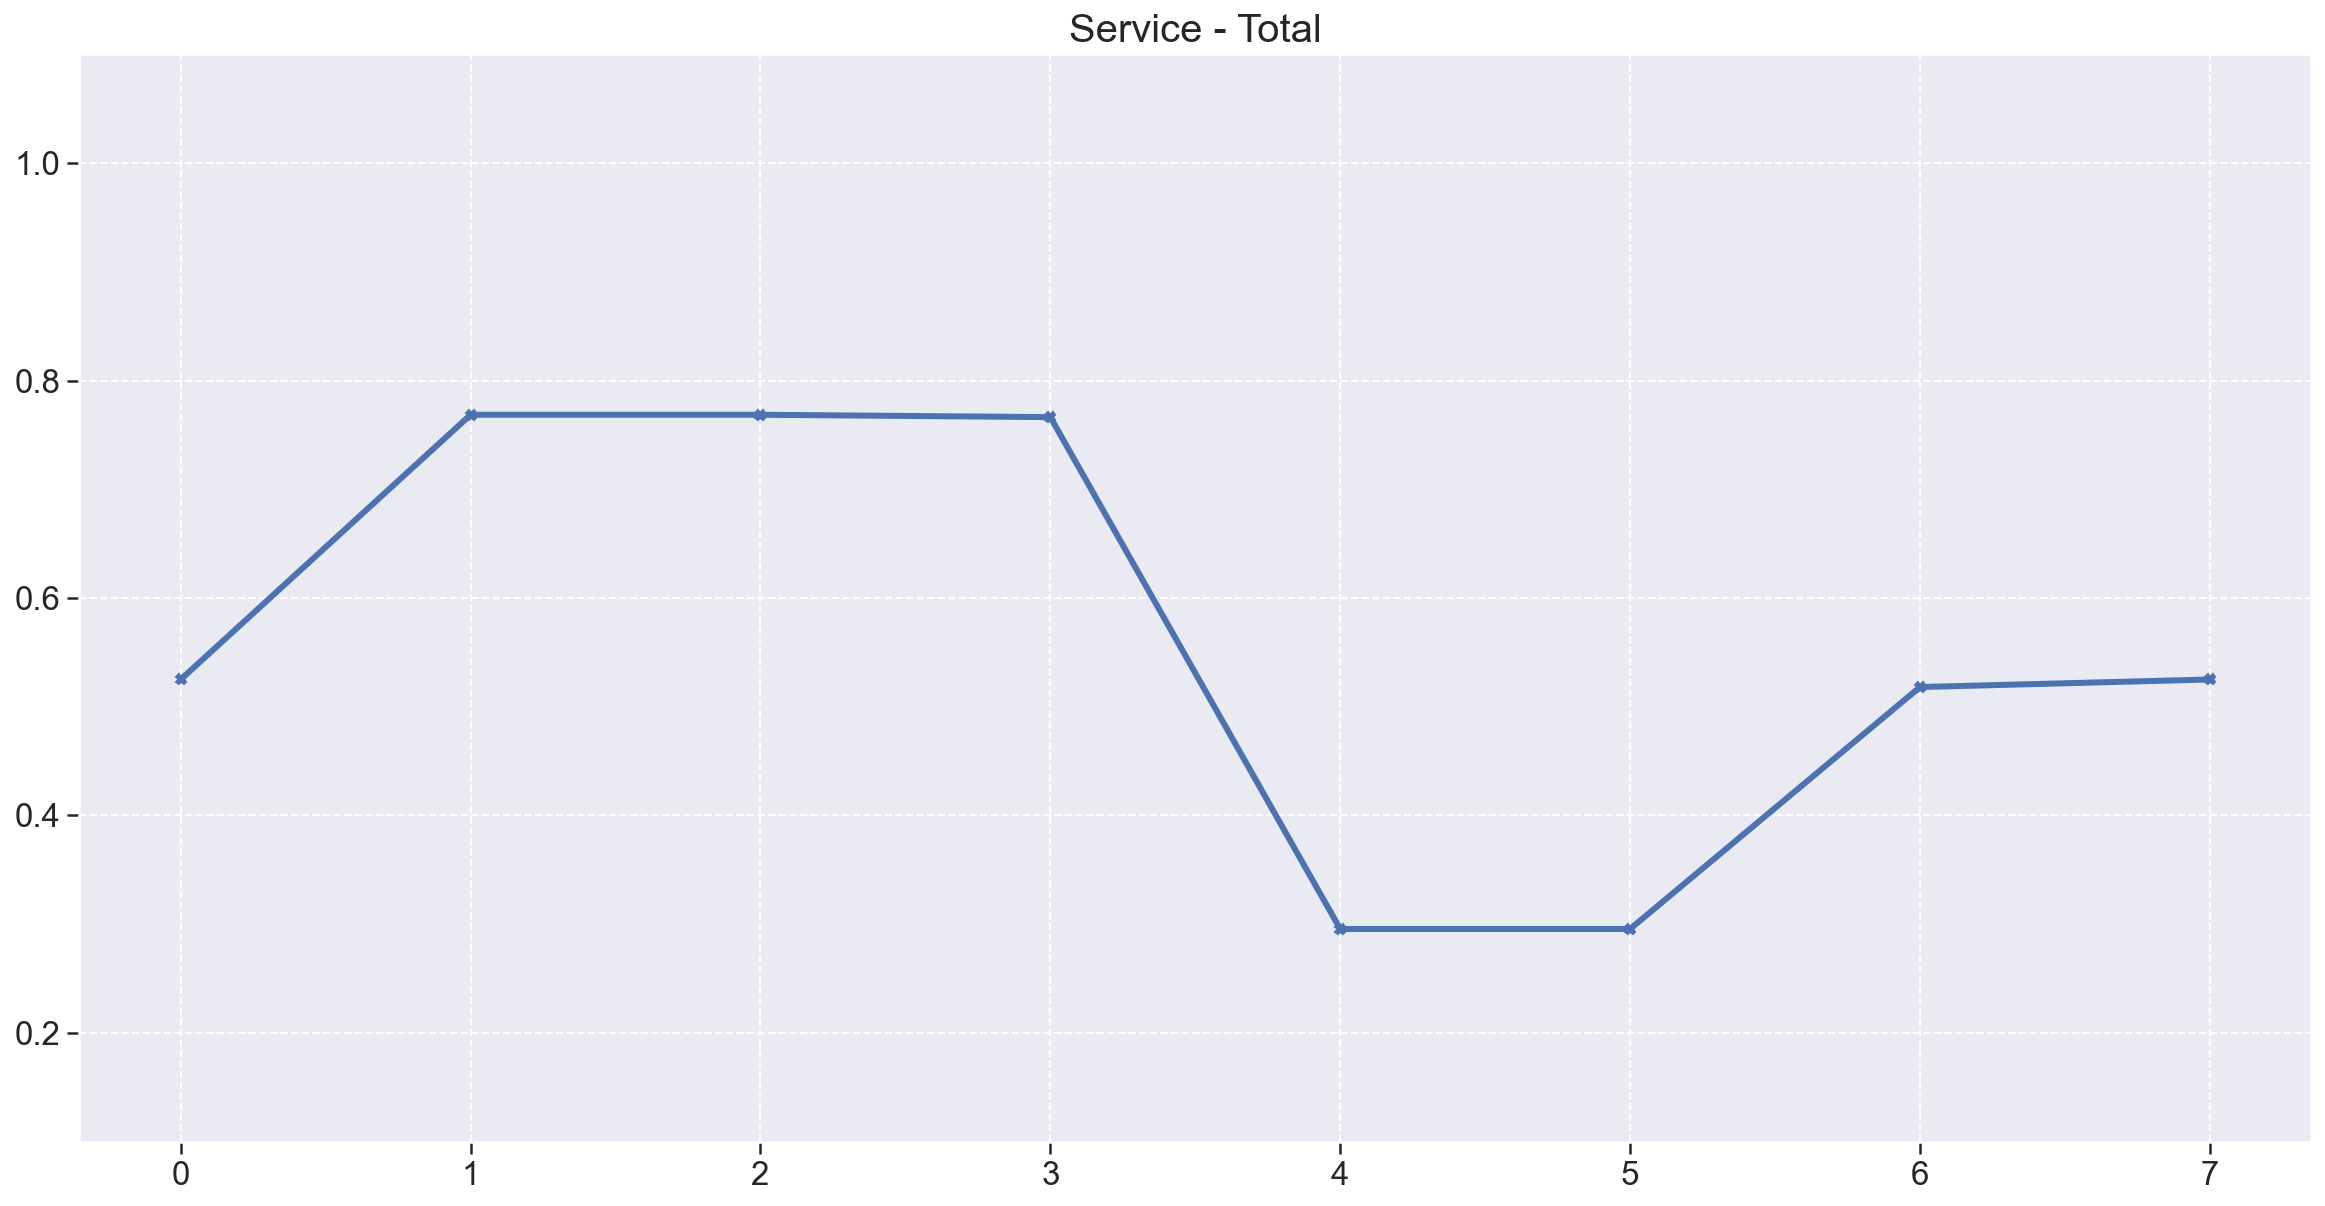

Front
Maintainability Stats
    mean     mode   median  std  var      min      max
0.291923 0.291923 0.291923  0.0  0.0 0.291923 0.291923
Reliability Stats
   mean    mode  median  std  var     min     max
0.43956 0.43956 0.43956  0.0  0.0 0.43956 0.43956


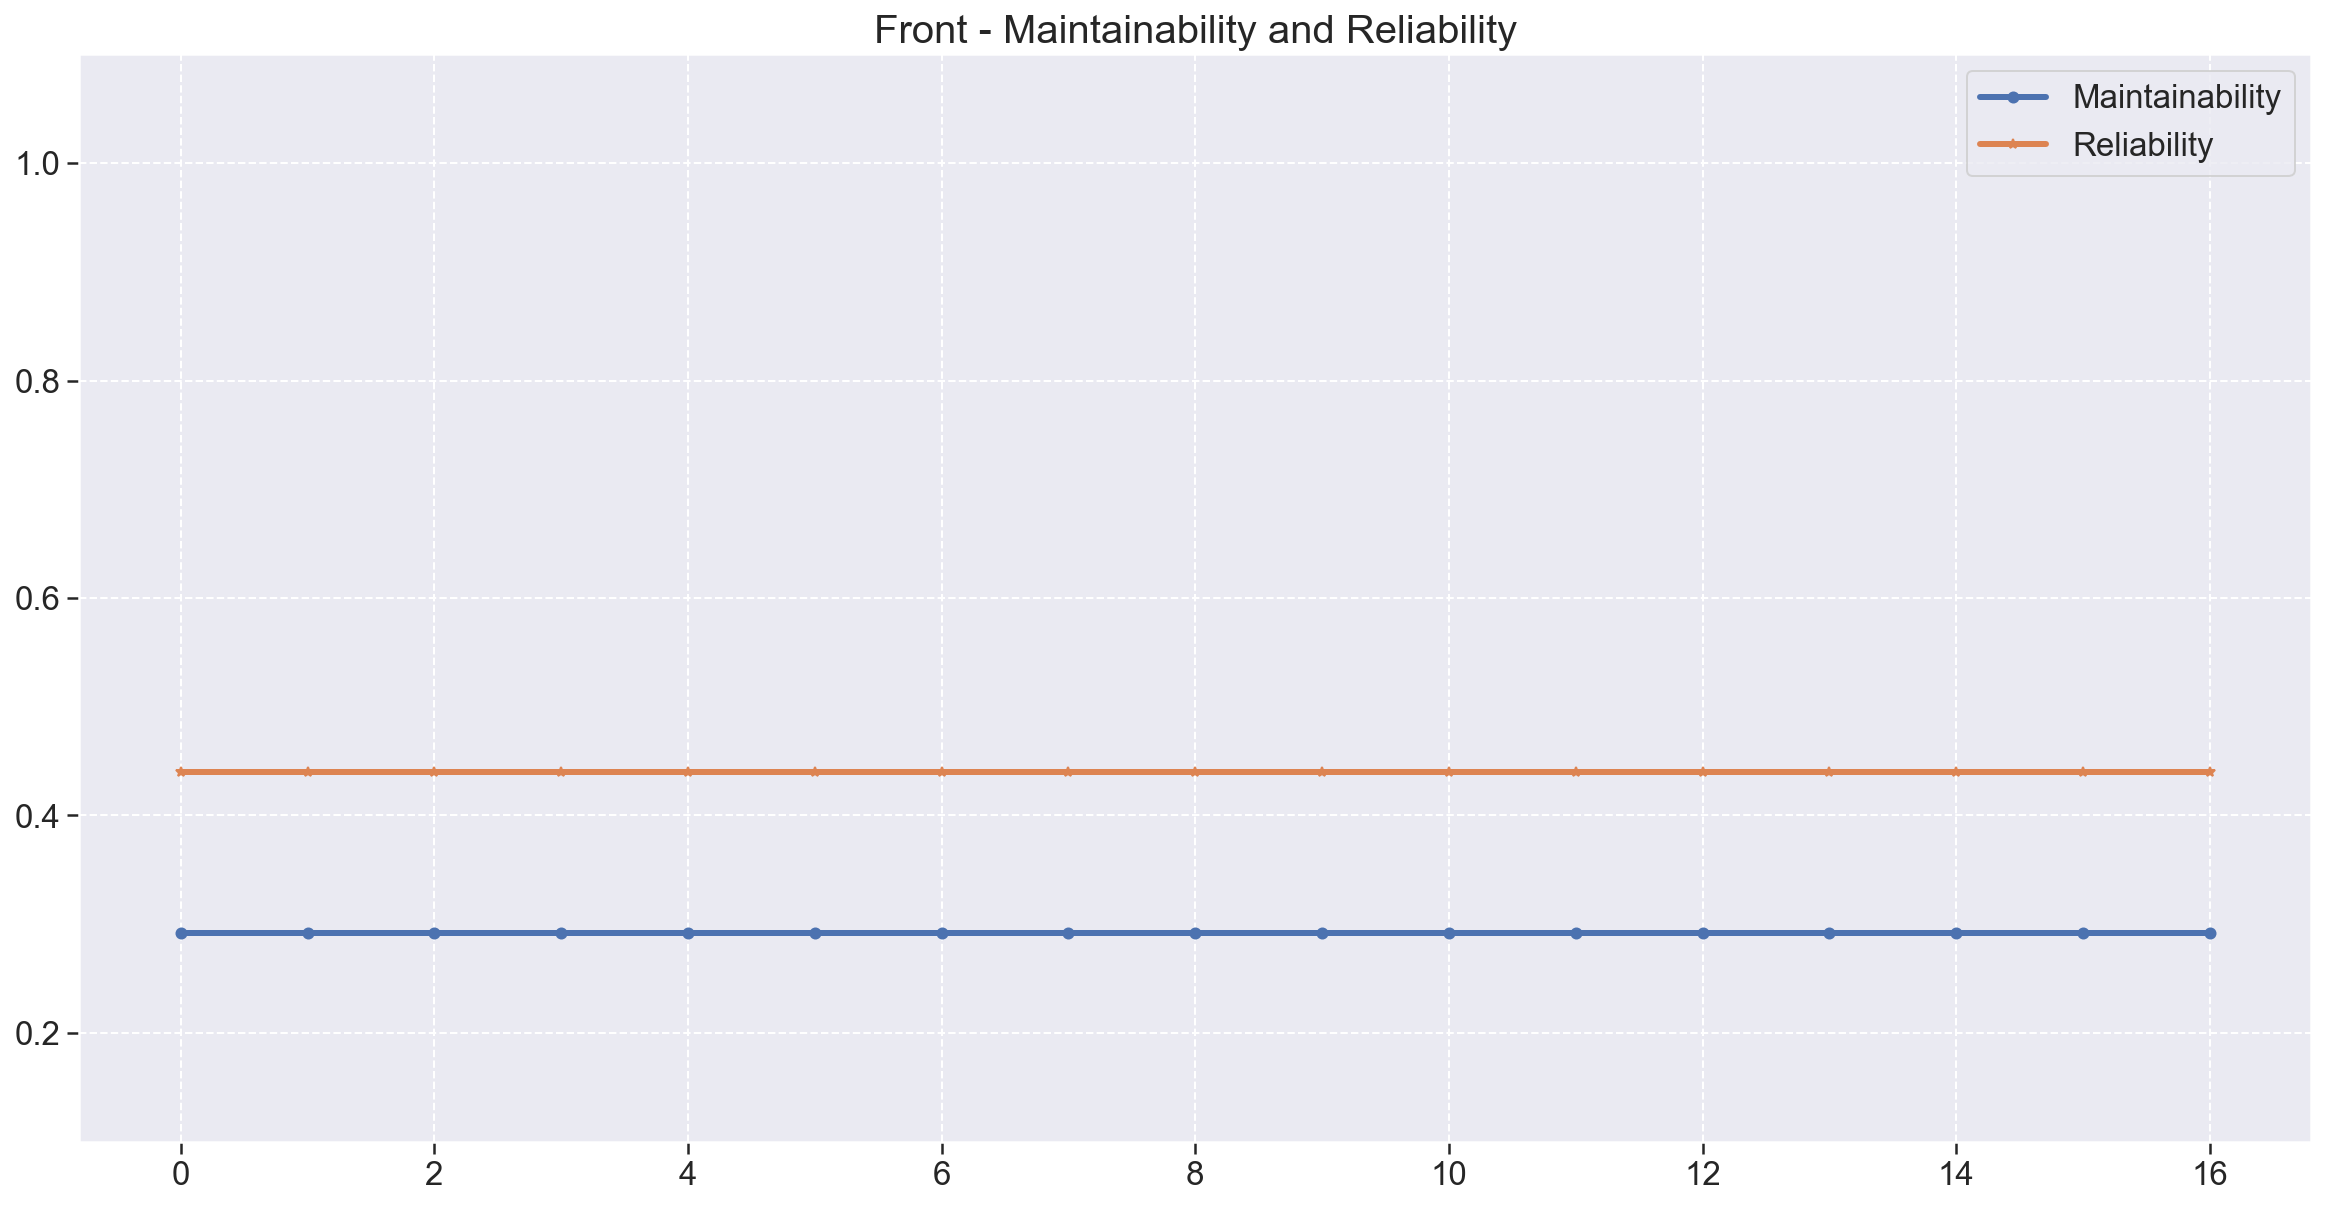

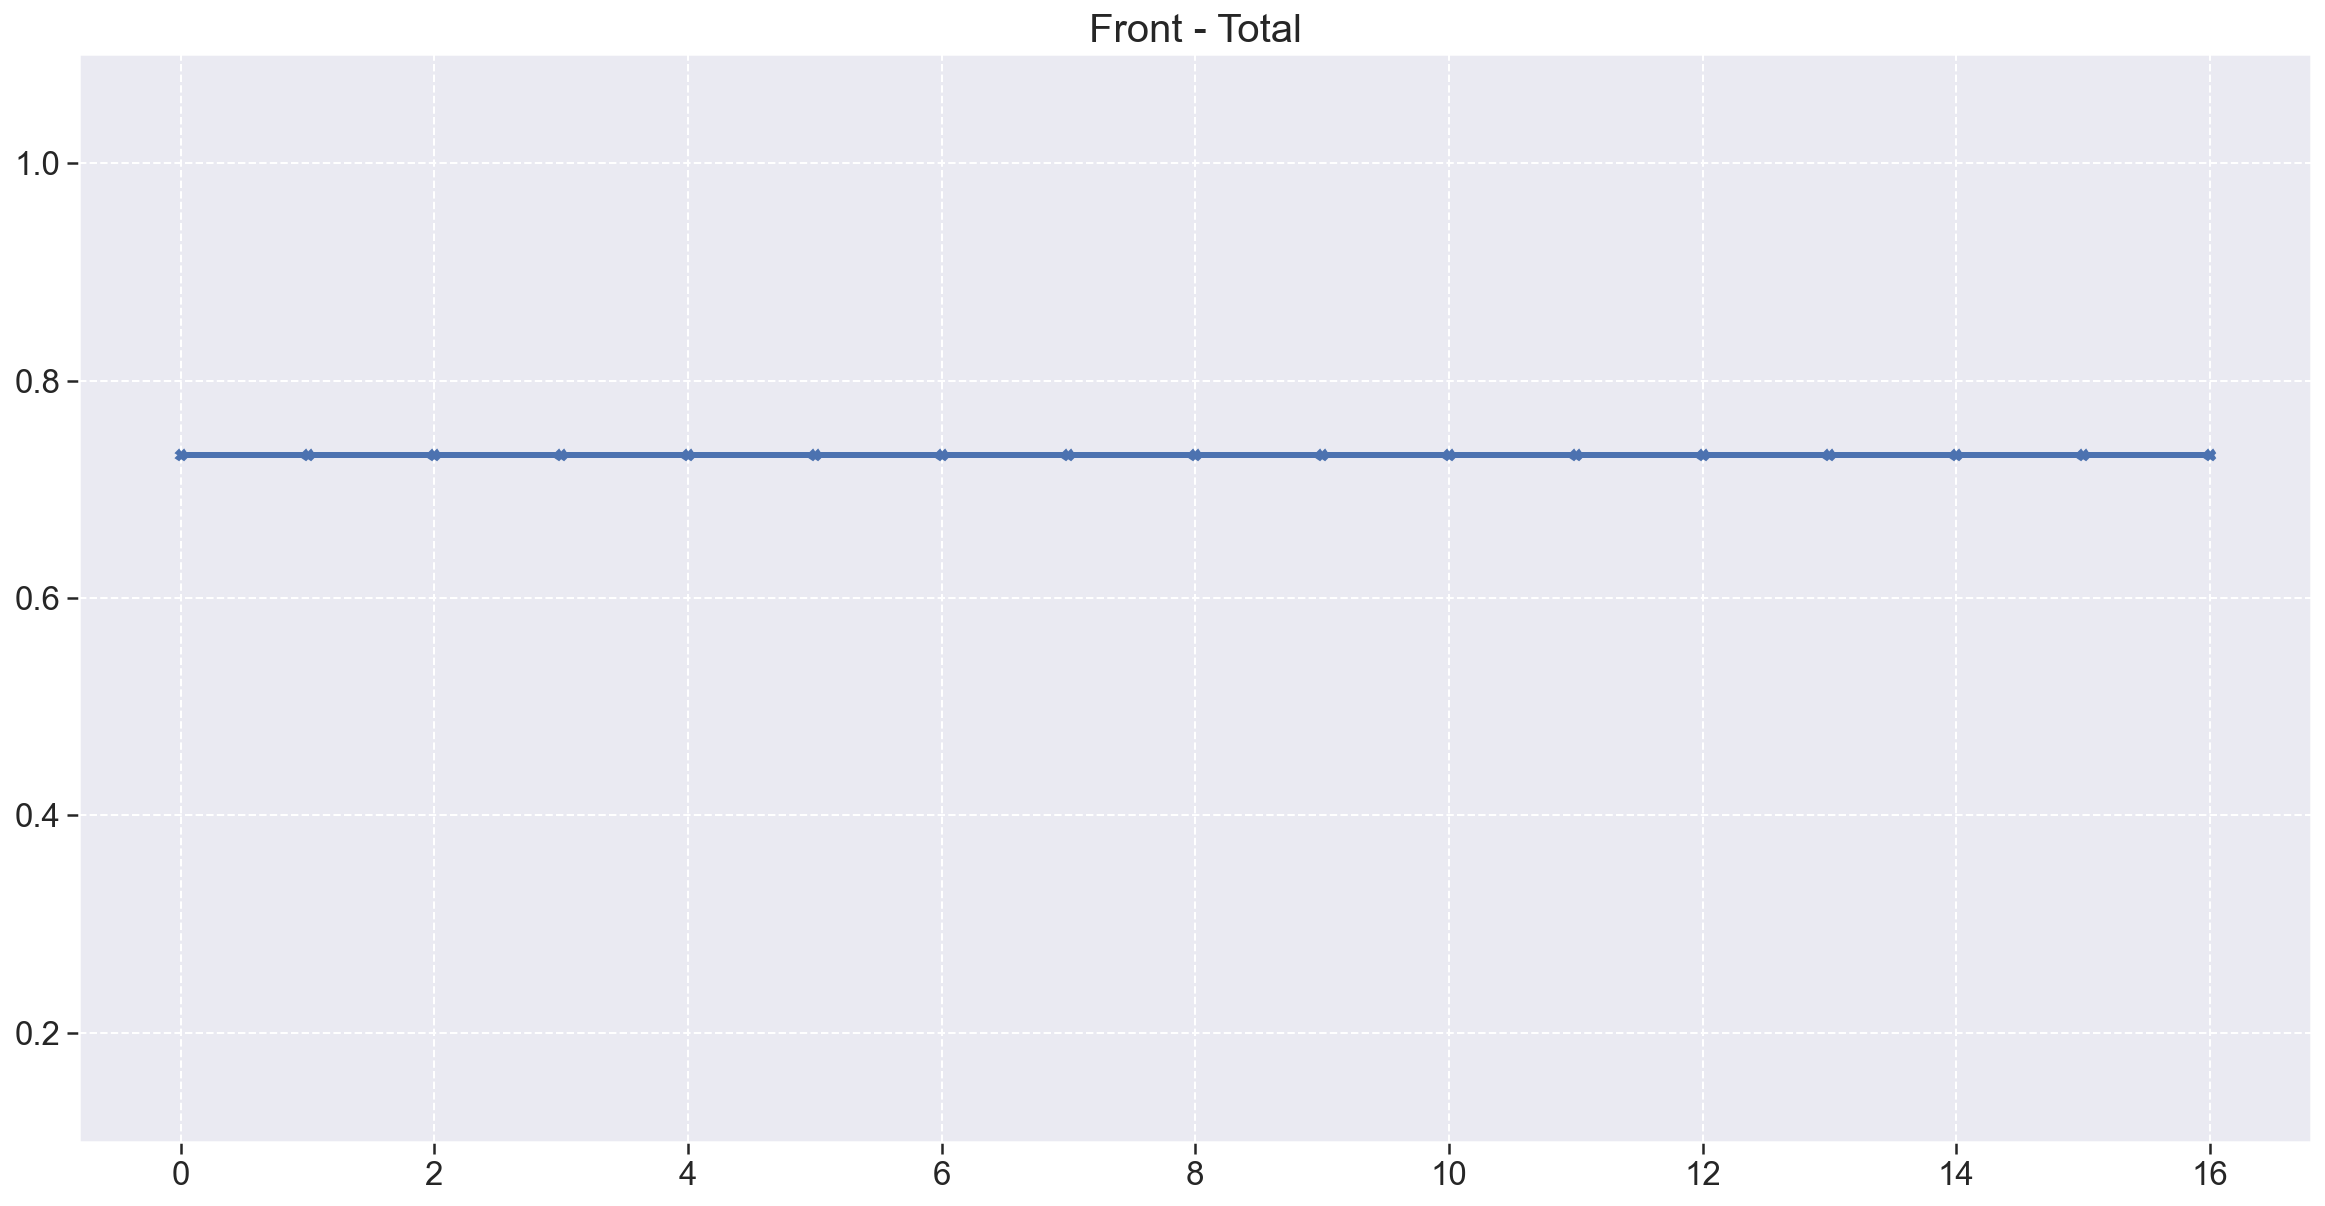

In [63]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

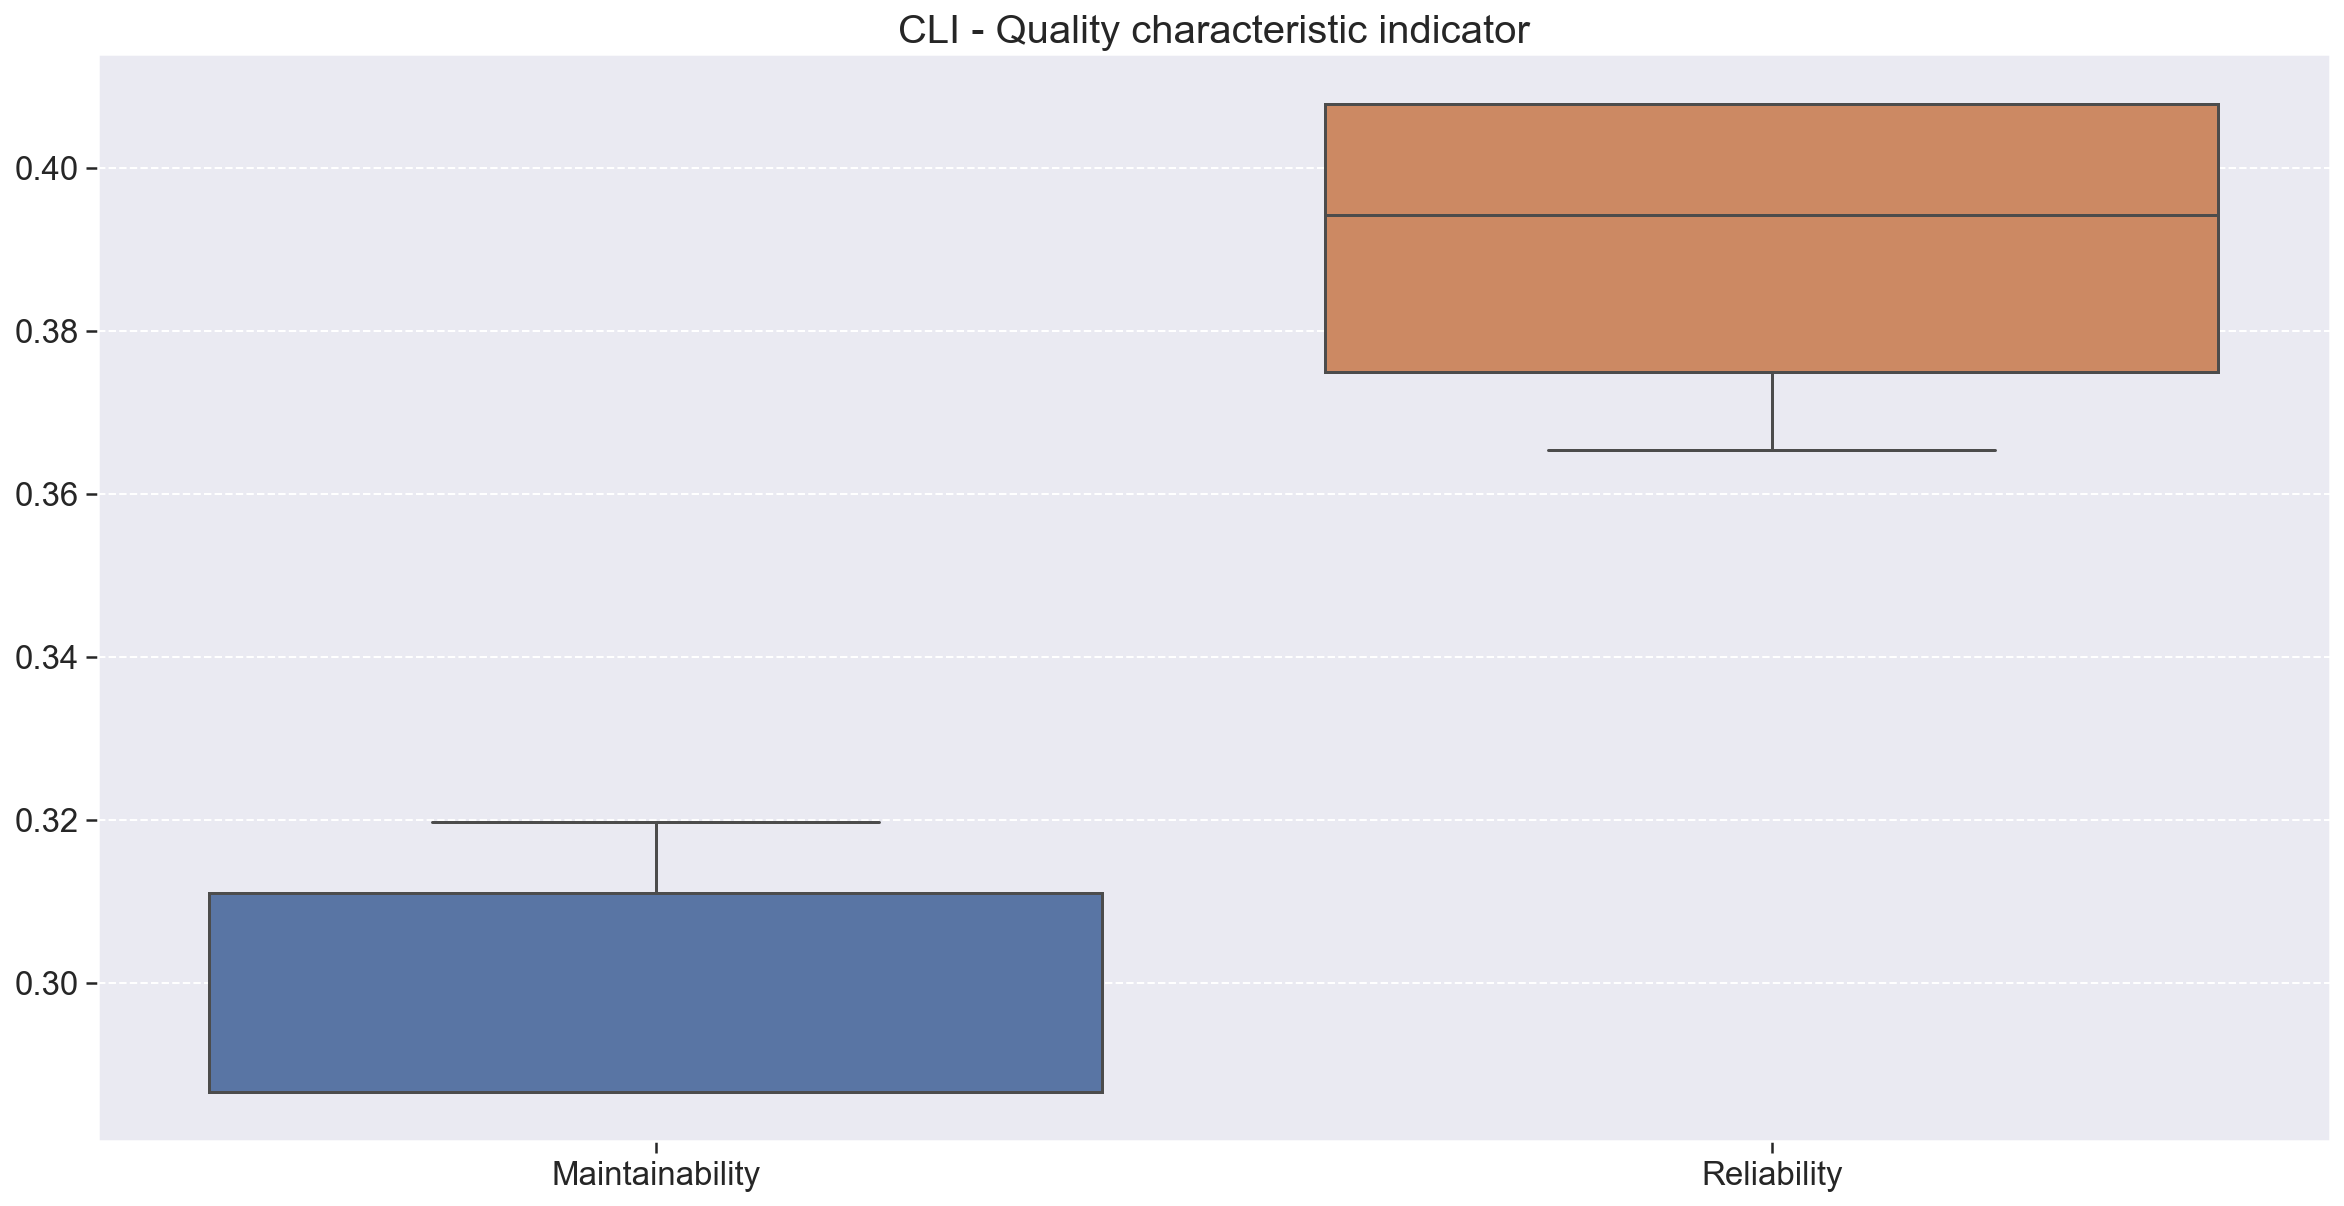

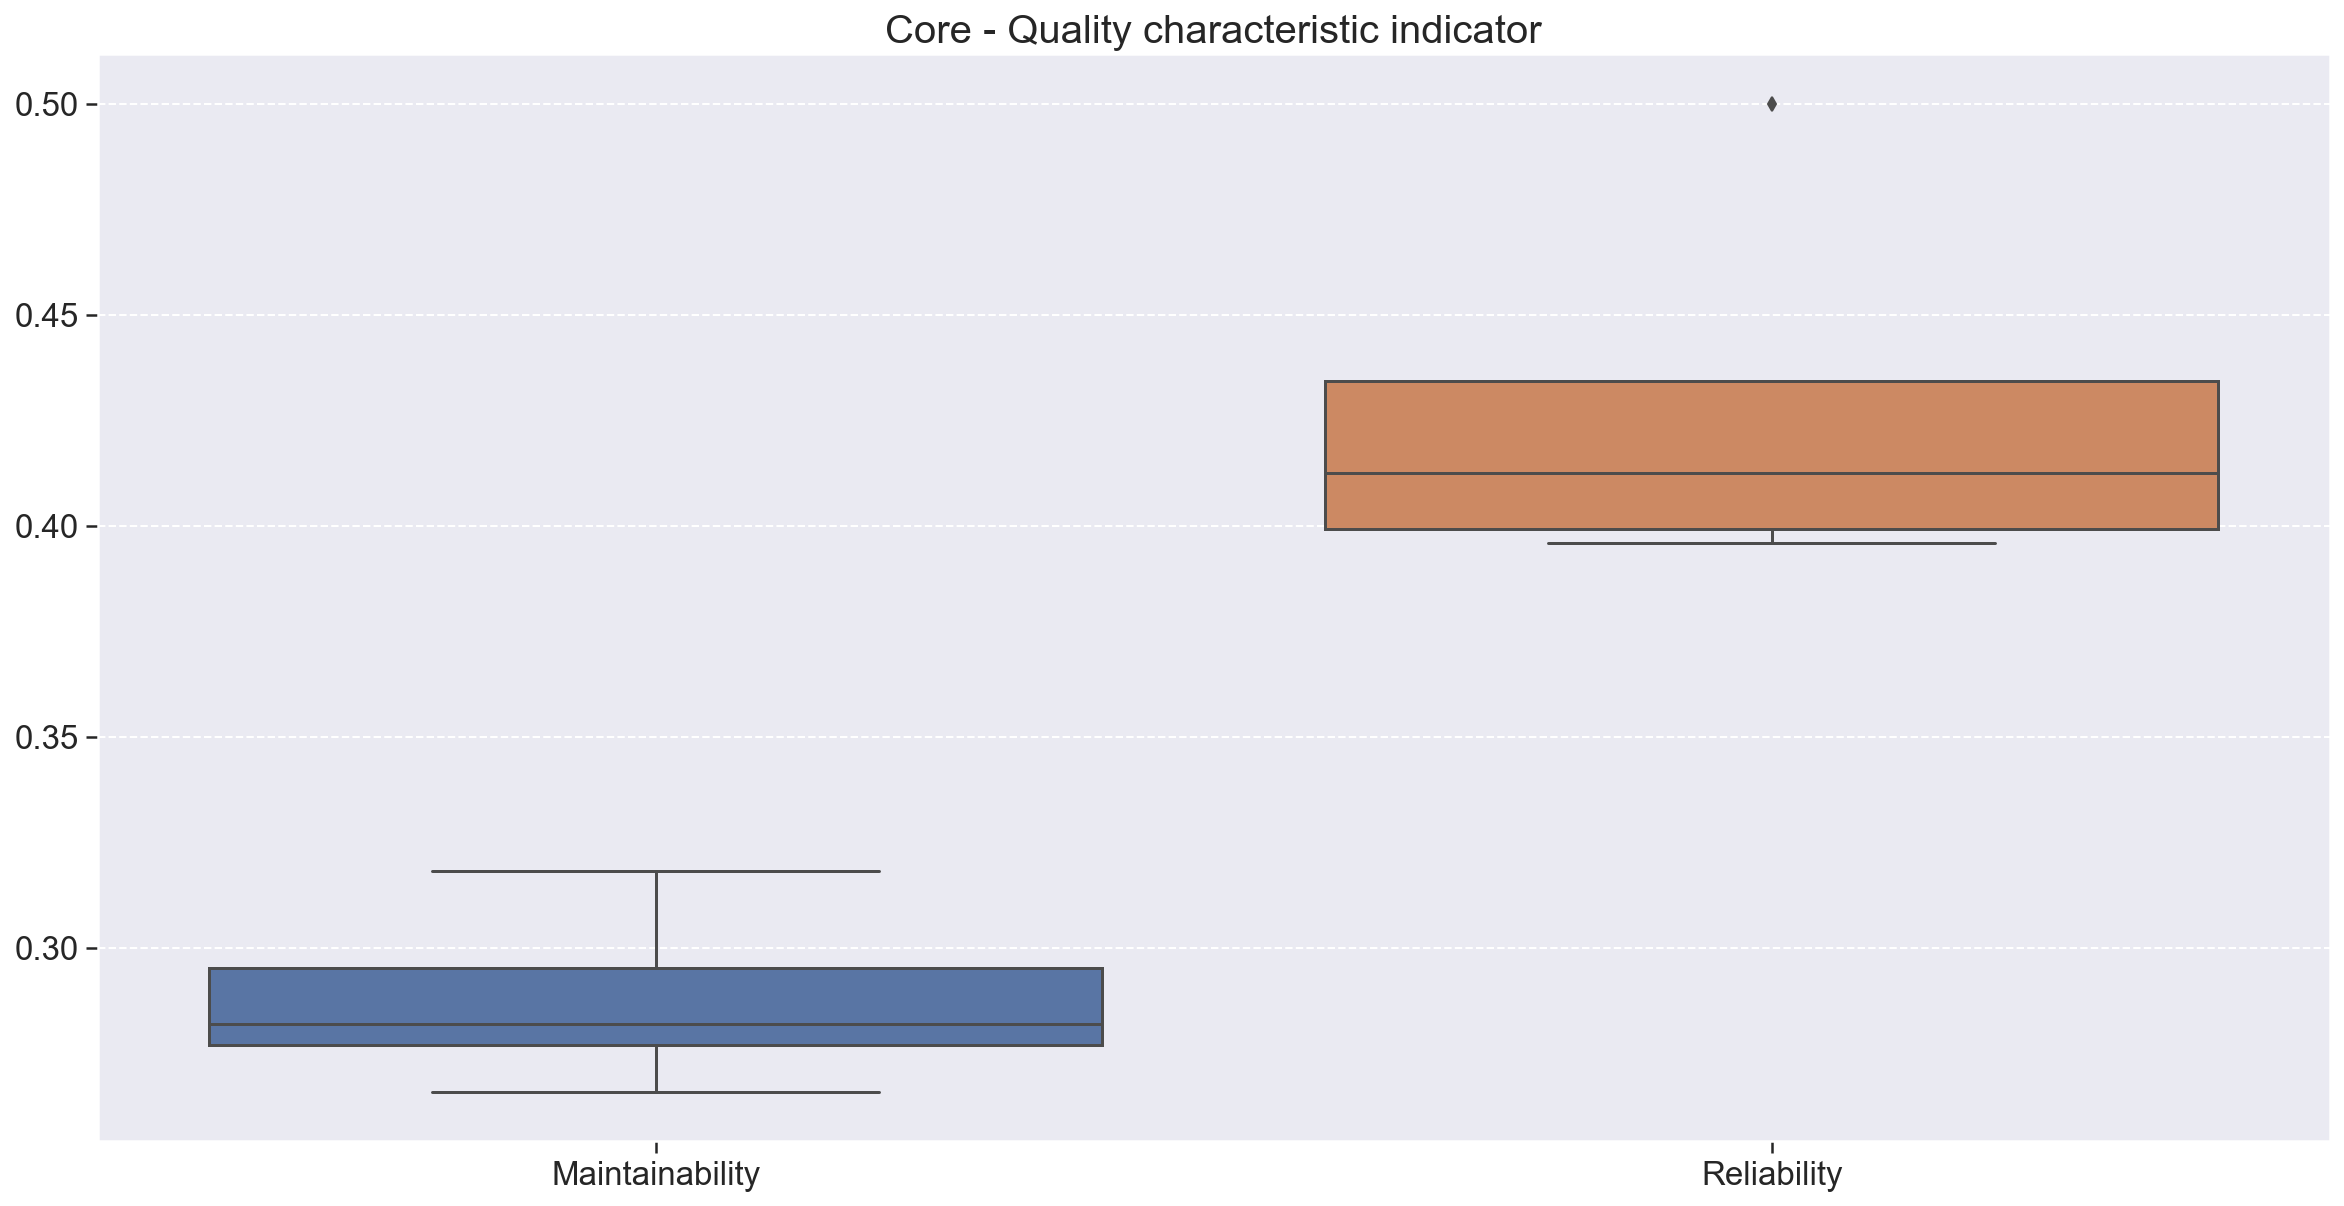

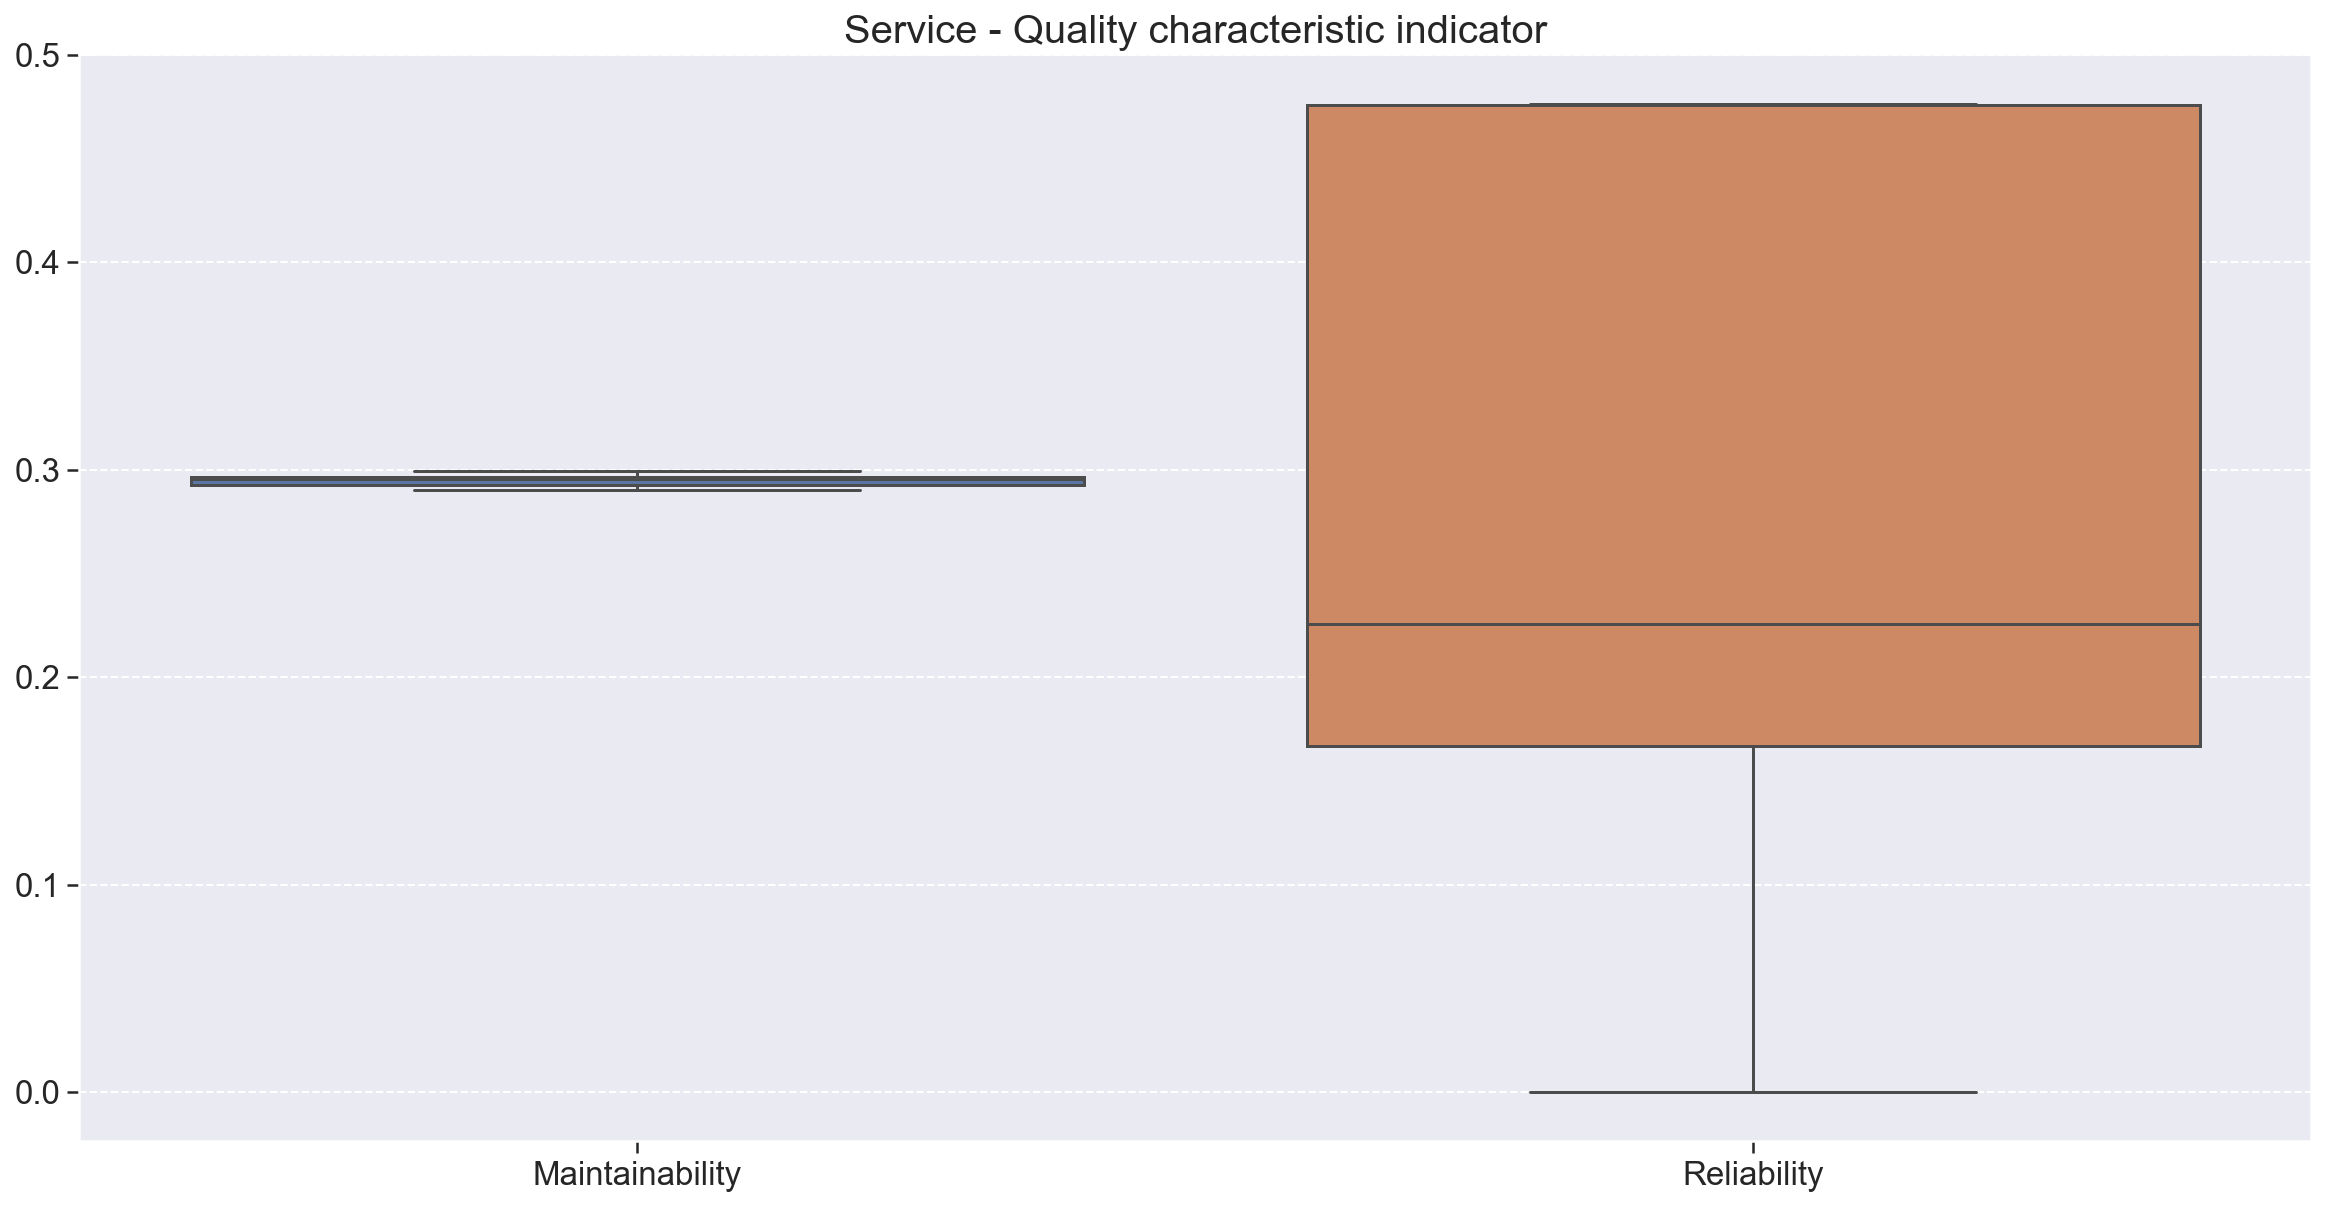

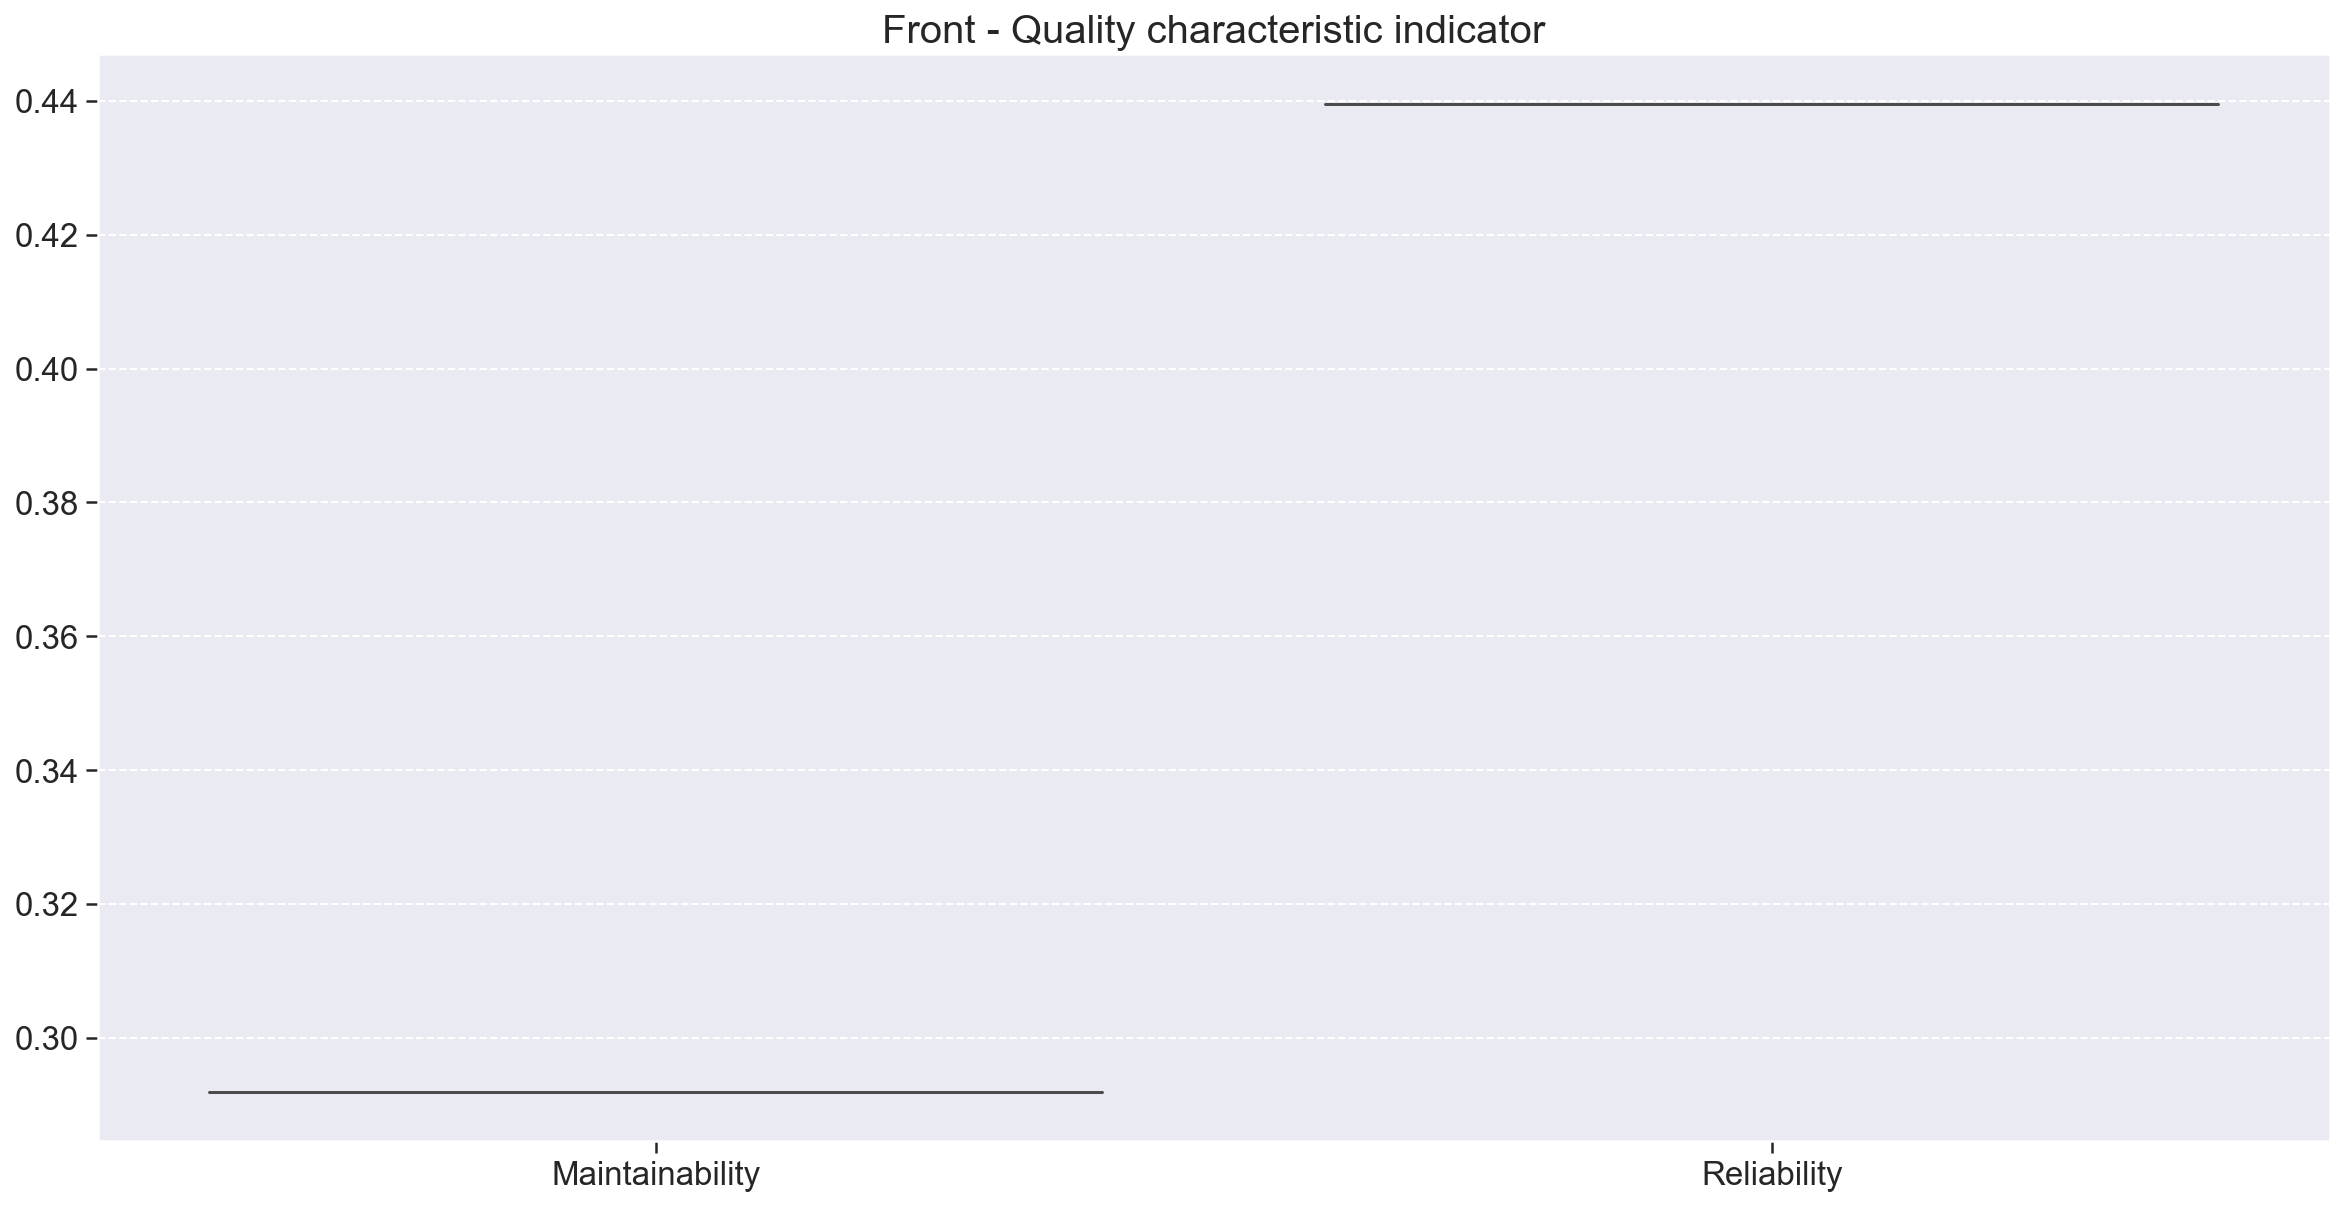

In [64]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

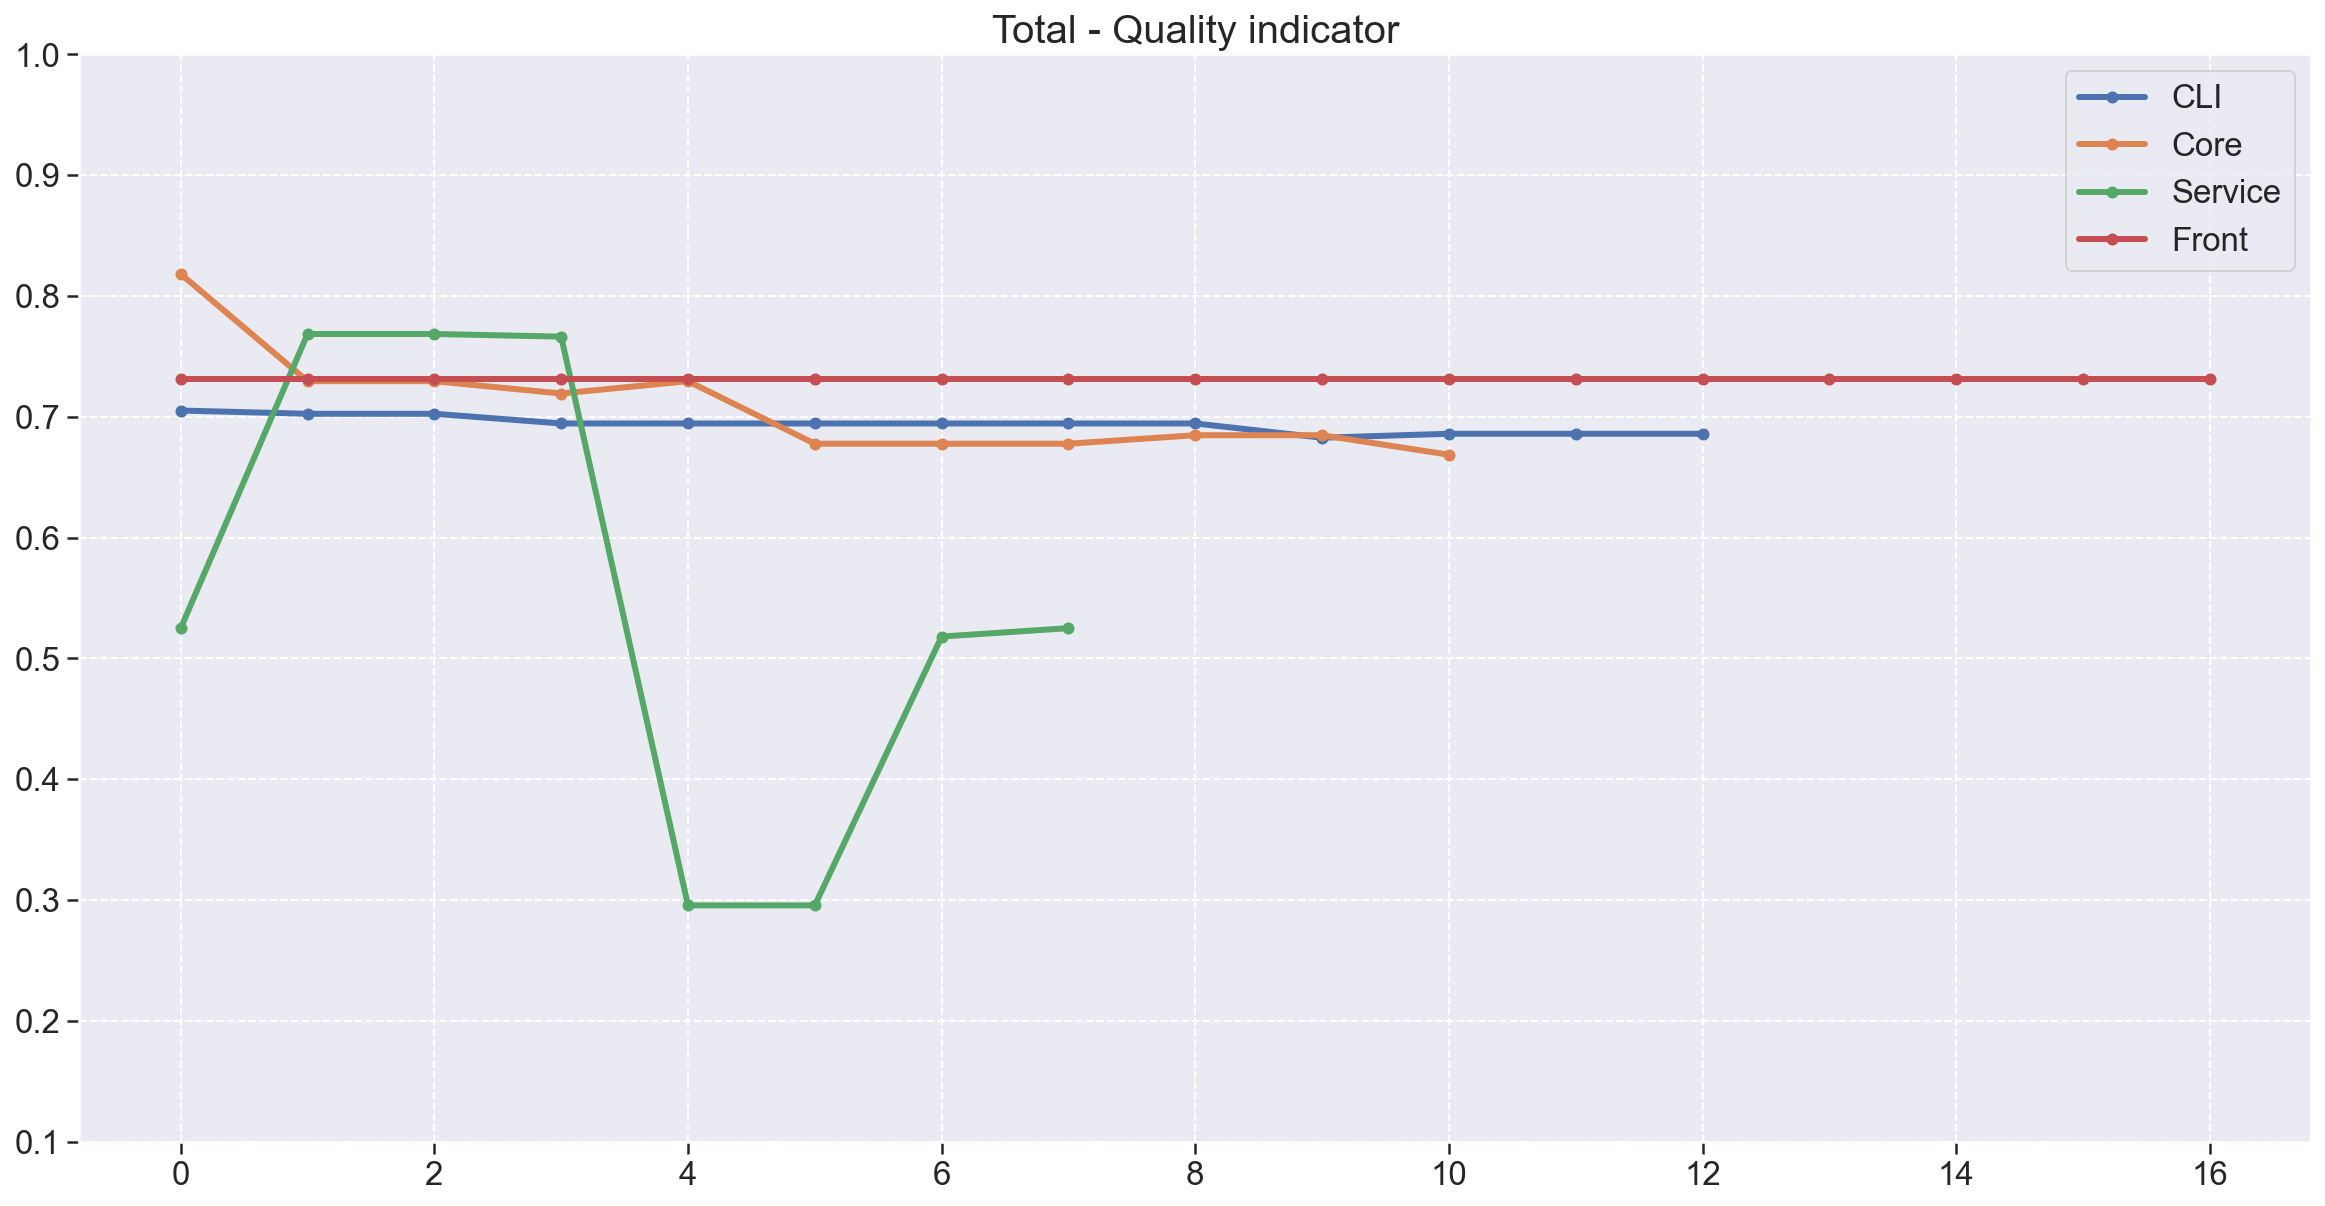

In [65]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=5, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [66]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2022-2-MeasureSoftGram--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2022-2-MeasureSoftGram--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.846154,0.038462,1.000000,1.0,1.0,0.576923,fga-eps-mds-2022-2-MeasureSoftGram-CLI,01-05-2023-21-40-30,7868,0.621923,0.788462,0.310962,0.394231,0.705192
1,0.875000,0.062500,1.000000,1.0,1.0,0.531250,fga-eps-mds-2022-2-MeasureSoftGram-CLI,01-05-2023-23-50-53,8916,0.639375,0.765625,0.319688,0.382812,0.702500
2,0.875000,0.062500,1.000000,1.0,1.0,0.531250,fga-eps-mds-2022-2-MeasureSoftGram-CLI,01-27-2023-03-31-51,8916,0.639375,0.765625,0.319688,0.382812,0.702500
3,0.684211,0.052632,1.000000,1.0,1.0,0.631579,fga-eps-mds-2022-2-MeasureSoftGram-CLI,01-27-2023-03-42-06,2866,0.573158,0.815789,0.286579,0.407895,0.694474
4,0.684211,0.052632,1.000000,1.0,1.0,0.631579,fga-eps-mds-2022-2-MeasureSoftGram-CLI,01-31-2023-17-54-12,2866,0.573158,0.815789,0.286579,0.407895,0.694474
5,0.684211,0.052632,1.000000,1.0,1.0,0.631579,fga-eps-mds-2022-2-MeasureSoftGram-CLI,02-01-2023-20-58-21,2932,0.573158,0.815789,0.286579,0.407895,0.694474
6,0.684211,0.052632,1.000000,1.0,1.0,0.631579,fga-eps-mds-2022-2-MeasureSoftGram-CLI,02-01-2023-21-11-28,2932,0.573158,0.815789,0.286579,0.407895,0.694474
7,0.684211,0.052632,1.000000,1.0,1.0,0.631579,fga-eps-mds-2022-2-MeasureSoftGram-CLI,02-06-2023-02-26-56,2932,0.573158,0.815789,0.286579,0.407895,0.694474
8,0.684211,0.052632,1.000000,1.0,1.0,0.631579,fga-eps-mds-2022-2-MeasureSoftGram-CLI,02-06-2023-02-31-57,2932,0.573158,0.815789,0.286579,0.407895,0.694474
9,0.846154,0.076923,1.000000,1.0,1.0,0.461538,fga-eps-mds-2022-2-MeasureSoftGram-CLI,11-26-2022-17-47-19,7621,0.634615,0.730769,0.317308,0.365385,0.682692


### 1) Qual é o microsserviço de backend que apresenta o pior indicador de manutenibilidade e o que foi feito por seu time para melhora-lo?

O microsserviço do backend que apresenta o pior indicador de manutenabilidade, a princípio, é o Core. Entretando, essa é uma análise do projeto como um todo, porque durante a metade do percurso a CLI teve uma queda em decorrência do empacotamento e da nova interface visual que foi implementada. Por não possuir uma diferença gritante em comparação aos outros repositórios (CLI e Service), apenas foi mantida o fluxo de desenvolvimento desse repositório, visto que a equipe esteve, boa parte do tempo, focada em realizar a refatoração da CLI para abrigar a nova Core que estava sendo empacotada. Em relação ao período de tempo que a CLI teve uma queda no indicador de manutenibilidade, a equipe buscou, em __releases__ posteriores corrigir isso, removendo e refatorando código duplicado que foi adicionado durante o empacotamento da aplicação.

### 2) No microsserviço que apresentar o pior indicador de confiabilidade, mostre qual(is) o(s) módulos/arquivos mais críticos e explique como seu time tratou esse problema.

Referente ao indicador de confiabilidade, o microsserviço que apresentou pior desempenho foi o repositório da Service, devido principalmente a ser uma base de código muito extensa, sem uma cobertura de testes apropriada. Os módulos mais críticos eram os referentes a utilização do Core client pois exigiam testes de integração e que a parte do Core fosse __mockada__ para funcionar, a solução proposta pelo time foi com o empacotamento da Core trazer mais confiabilidade ao código no sentido de que os comportamentos seriam plenamente testados com o auxílio de uma biblioteca em detrimento a um serviço externo. O time realizou testes no ínicio do projeto para se familiarizar com código, o que gerou um aumento no índice de confiabilidade, logo após, percebe-se uma queda referente ao período de transição do código, e novamente se observa um aumento no índice quando o pacote da Core é lançado e os testes na Service são possíveis de serem feitos.

### 3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento do projeto relacionado ao seu time.

Analisando-se a qualidade do produto durante o tempo de desenvolvimento do projeto, é perceptível que nos repositórios que foram pontos focais das releases (Core e CLI) a qualidade se manteve "constante", tendo uma queda inicial por conta da necessidade do desenvolvimento da funcionalidade em detrimento à qualidade do código.

Ainda referente aos repositórios da Core e da CLI, a impressão é que houve uma queda constante nos gráficos, mas não é o que de fato aconteceu com o código, esses repositórios passaram por algumas refatorações, porém, todas orientadas a testes, e isso não é expresso no índice de confiabilidade desses repositórios, pois, alguns arquivos desnecessários para se considerar no coverage, estão sendo considerados no analytics, e isso impacta bastante na qualidade desses códigos, pois são arquivos extensos como os arquivos estáticos da Core, ou arquivos de setup da CLI como o setup_log. Enfim, essa falsa indicação de queda se deve ao fato do perfil do time estar voltado ao desenvolvimento e a parte de gerenciamento, como configurações do sonar e do analytics serem concentradas em poucas pessoas.

Em relação à Service, é perceptível uma queda considerável na sua qualidade em decorrência da baixa confiabilidade que foi alcançada durante a execução do projeto. Além dos motivos citados no questionamento anterior (sobre confiabilidade), é visível que um dos fatores que também influênciou essa queda está na pequena quantidade de membros do projeto que atuaram no código. Essa afirmação também é refletida no Frontend, que apesar de parecer ter se mantido constante, não representa a realidade, pois os __commits__ começaram a ser feitos apenas em meádos do último mês de projeto e todas as análises existentes, ou são de análises repetidas ou são inválidas.
